# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submitting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [2]:
from grader import Grader

In [3]:
grader = Grader()

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kuldeep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [5]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [6]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [7]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [8]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [9]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [10]:
import re

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)# delete stopwords from text
    return text

In [12]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [13]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [14]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [15]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [16]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [53]:
tags_counts = {}
for tags in y_train:
    for tag in tags:
        print(tag)
        if tag in tags_counts:
            tags_counts[tag] +=1
        else:
            tags_counts[tag]=1
tags_counts
word_counts = {}

r
php
mysql
c#
javascript
jquery
java
ruby-on-rails
ruby
ruby-on-rails-3
json
ruby
java
spring
spring-mvc
php
codeigniter
java
class
javascript
jquery
html
ios
javascript
jquery
c++
eclipse
javascript
python
list
ios
objective-c
ios
json
swift
c#
xaml
c#
asp.net
c#
wpf
multithreading
python
ruby
php
image
codeigniter
java
performance
javascript
jquery
twitter-bootstrap
c#
linq
python
xml
c#
python
python
numpy
javascript
jquery
ruby
javascript
jquery
ajax
json
c#
json
django
javascript
java
multithreading
php
jquery
ajax
laravel
javascript
jquery
ajax
r
java
android
rest
c++
c#
asp.net
asp.net-mvc
web-services
c#
linq
javascript
string
java
excel
python
c#
mysql
winforms
java
php
mysql
c#
asp.net
asp.net-mvc
java
arrays
php
java
python
c++
c
sockets
ruby-on-rails
osx
c
php
laravel
c#
asp.net
entity-framework
javascript
c#
linq
list
mongodb
javascript
html
java
json
javascript
jquery
android
c++
opencv
php
c#
wpf
ios
xcode
swift
uitableview
c++
c
algorithm
javascript
php
javascript
ajax

twitter-bootstrap
c#
asp.net
java
c++
c
linux
java
javascript
regex
javascript
html
eclipse
ios
objective-c
swift
javascript
jquery
c#
.net
ruby
javascript
c#
sql-server
winforms
javascript
android
c++
function
ruby-on-rails
xml
ruby
web-services
json
java
javascript
php
mysql
ruby-on-rails
php
facebook
javascript
jquery
html
css
java
php
mysql
sql
java
json
javascript
html
css
c++
string
javascript
python
pandas
java
c#
visual-studio-2010
unit-testing
generics
javascript
angularjs
javascript
arrays
c++
c#
ios
objective-c
xcode
swift
c
php
php
function
python
c++
multithreading
javascript
html
css
twitter-bootstrap
vb.net
visual-studio-2010
php
regex
java
ios
objective-c
xml
javascript
html
css
html5
java
spring
java
windows
django
php
javascript
jquery
c++
c#
entity-framework
java
loops
c#
java
python
list
python
image
php
file
javascript
html
c#
linq
list
csv
c#
wpf
xaml
javascript
c#
javascript
jquery
json
c
ruby-on-rails
json
java
android
sockets
java
swing
python
function
ruby
reg

c#
.net
multithreading
java
apache
r
c#
.net
linq
c
pointers
c#
xaml
python
qt
php
apache
javascript
angularjs
python
java
swift
java
spring
php
python
c#
asp.net
ajax
c#
linq
list
python
algorithm
list
ruby-on-rails
ruby
java
hibernate
ios
objective-c
javascript
jquery
html
forms
c#
c#
.net
entity-framework
javascript
python
java
android
eclipse
php
function
c++
java
c
visual-studio
objective-c
objective-c
c#
python
python-2.7
javascript
jquery
java
android
rest
python
php
string
javascript
html
javascript
jquery
javascript
asp.net-mvc
ajax
javascript
performance
python
string
list
c#
loops
php
jquery
html
c++
php
mysql
javascript
c++
c
python
python-2.7
python
ruby-on-rails
python
ruby-on-rails
java
sql-server
linux
c#
asp.net
asp.net-mvc
javascript
c#
linq
python
php
jquery
ajax
c#
.net
arrays
c#
c++
java
java
javascript
jquery
html
dom
javascript
jquery
javascript
php
php
java
javascript
google-maps
java
android
javascript
angularjs
c#
winforms
image
php
java
android
python
string


c#
winforms
c#
ruby-on-rails
ruby
arrays
ruby-on-rails
ruby
java
ruby-on-rails
json
ruby-on-rails-3
c#
regex
c#
asp.net
session
java
android
objective-c
ios
cocoa-touch
ruby
windows
ruby-on-rails
ruby
ruby-on-rails-3
python
python-3.x
ios
objective-c
javascript
php
sql
sql-server
python
java
javascript
jquery
html
css
php
php
mysql
json
java
java
selenium
javascript
jquery
css
c#
winforms
javascript
jquery
html
c#
c#
asp.net
c#
visual-studio-2010
linq
entity-framework
objective-c
xcode
c++
pointers
java
android
javascript
file
c#
winforms
php
codeigniter
java
javascript
html
ruby-on-rails
c#
excel
c#
.net
list
c++
visual-studio
javascript
jquery
twitter-bootstrap
php
mysql
javascript
node.js
java
swing
c#
xml
linq
javascript
jquery
ajax
c#
sql
iphone
objective-c
ios
php
mysql
c#
web-services
javascript
jquery
ajax
c#
java
sql
c++
javascript
c#
winforms
file
java
c
ruby-on-rails
ruby
osx
r
python
php
jquery
ajax
forms
java
spring-mvc
c#
linq
java
hibernate
java
java
spring
hibernate
php

list
sorting
python
python
python-2.7
php
jquery
java
php
php
html
c++
c++
windows
c#
asp.net
java
r
c++
javascript
jquery
php
mysql
java
json
spring
rest
spring-mvc
java
android
c++
arrays
javascript
java
php
java
c
php
linux
apache
c
java
c++
javascript
jquery
ajax
django
javascript
jquery
codeigniter
python
python
javascript
c#
php
c#
c#
php
class
php
forms
php
mysql
string
python
c++
windows
java
xml
maven
python
django
python
django
c++
qt
php
loops
java
json
parsing
objective-c
ios
image
javascript
html
dom
java
c
objective-c
java
python
arrays
numpy
ruby
c#
asp.net
ruby-on-rails
ruby
ruby-on-rails-3
javascript
php
mysql
sql
session
c#
entity-framework
objective-c
python
ajax
django
javascript
node.js
c#
.net
objective-c
javascript
java
android
java
java
php
javascript
windows
html5
dom
php
javascript
angularjs
node.js
c++
multithreading
javascript
angularjs
javascript
html
angularjs
c
linux
javascript
node.js
php
html
mysql
java
c#
xml
c++
c
linux
multithreading
javascript
java


java
multithreading
c#
xml
mysql
ruby-on-rails
php
javascript
node.js
javascript
c#
java
angularjs
spring
rest
spring-mvc
php
jquery
java
jsp
javascript
jquery
java
java
python
java
eclipse
javascript
css
html5
java
multithreading
sockets
c++
class
opencv
vb.net
java
ios
swift
ruby-on-rails
php
c
php
c#
.net
multithreading
javascript
python
linux
django
python
pandas
c#
asp.net
python
sockets
c#
asp.net
python
php
c#
linq
c#
javascript
ruby-on-rails
ruby-on-rails-3
javascript
jquery
angularjs
php
session
java
spring
c#
.net
winforms
iphone
objective-c
ios
javascript
jquery
ajax
python
vb.net
php
html
function
javascript
regex
c#
asp.net
iphone
objective-c
java
android
java
multithreading
c++
list
c#
c
java
ruby-on-rails
java
javascript
jquery
dom
javascript
node.js
c++
ruby-on-rails
database
php
python
pandas
java
hibernate
python
sorting
php
iphone
objective-c
cocoa-touch
r
c
python
c#
asp.net
asp.net-mvc
android
c++
objective-c
vb.net
c++
php
php
javascript
html
javascript
python
jav

database
android
c++
php
mysql
sql
database
java
php
class
function
c#
string
list
c++
php
regex
laravel
php
javascript
jquery
html
twitter-bootstrap
c#
python
php
java
c
linux
c#
python
ios
objective-c
image
javascript
jquery
javascript
php
javascript
jquery
ajax
json
java
maven
c
c++
database
qt
python
opencv
java
spring
jsp
spring-mvc
javascript
javascript
java
ajax
java
session
c++
python
c#
.net
php
web-services
rest
r
java
php
codeigniter
java
xml
python
oop
class
python-3.x
python
python-2.7
java
jsp
session
c#
.net
java
android
php
php
mysql
c#
php
ruby
javascript
c#
.net
winforms
python
python-2.7
python
mysql
c#
asp.net
javascript
iphone
ios
objective-c
javascript
java
oop
c++
c#
sql-server
arrays
java
file
c#
linq
sorting
ruby-on-rails
xml
ruby
android
python
ios
java
android
javascript
jquery
json
ruby-on-rails
c#
winforms
ruby-on-rails
java
php
mysql
r
php
xml
java
php
image
c#
asp.net
javascript
php
jquery
mysql
php
java
android
generics
java
php
html
mysql
sql
arrays
rub

database
javascript
php
facebook
javascript
objective-c
cocoa-touch
javascript
jquery
iphone
objective-c
php
html
c#
visual-studio-2010
java
java
sorting
java
android
javascript
ruby
sockets
java
java
java
c++
vb.net
generics
c
php
linux
javascript
jquery
c#
.net
wpf
iphone
objective-c
c#
.net
visual-studio-2010
c#
file
csv
swift
c#
linq
python
java
java
spring
hibernate
validation
r
java
c#
.net
linq
javascript
html
java
arrays
java
php
mysql
database
c#
wpf
java
android
mysql
web-services
django
java
eclipse
java
php
javascript
java
android
django
facebook
c#
java
javascript
html
json
java
jsp
spring-mvc
javascript
arrays
java
c#
string
c#
r
php
mysql
javascript
jquery
javascript
jquery
python
regex
python-2.7
java
php
json
c#
c#
winforms
php
regex
string
c#
.net
wcf
python
csv
python
ruby
rest
database
django
javascript
regex
php
session
javascript
jquery
python
c#
winforms
multithreading
php
json
php
mysql
java
java
android
facebook
c#
winforms
java
jsp
c#
javascript
jquery
java
hi

c#
.net
c#
visual-studio-2010
php
wordpress
iphone
objective-c
c#
asp.net
asp.net-mvc
php
python
html
django
json
ruby-on-rails
ruby
javascript
jquery
html
java
c#
android
ios
javascript
jquery
ruby-on-rails
c#
.net
c#
java
eclipse
c#
entity-framework
javascript
javascript
jquery
python
django
c#
.net
unit-testing
ruby-on-rails
php
arrays
json
c#
ios
objective-c
cocoa-touch
javascript
ios
c#
datetime
php
python
java
php
arrays
vb.net
excel
java
jsp
servlets
javascript
html
css
java
arrays
c++
sorting
python
list
java
swing
java
android
php
java
c#
.net
asp.net
javascript
html
dom
java
php
apache
c++
java
sql-server
hibernate
php
android
c
java
java
performance
algorithm
iphone
objective-c
c#
python
csv
c#
asp.net
javascript
javascript
java
generics
c#
r
java
hibernate
vb.net
php
unit-testing
javascript
c#
sql
linq
iphone
objective-c
ios
cocoa-touch
javascript
jquery
css
angularjs
php
javascript
javascript
c#
asp.net
linq
entity-framework
c#
xml
c#
winforms
c#
winforms
java
php
codeigni

dom
java
spring
java
spring
javascript
angularjs
c#
sql
asp.net
php
javascript
jquery
ajax
php
json
javascript
jquery
python
java
android
php
session
.net
vb.net
c#
java
swift
objective-c
ios
java
selenium
c++
c
opencv
java
android
javascript
java
swing
c++
ios
swift
c#
xaml
objective-c
osx
objective-c
ios
cocoa-touch
python
django
datetime
c#
linq
r
java
javascript
asp.net
html
ruby
php
arrays
c
javascript
android
java
file
c#
java
javascript
jquery
angularjs
javascript
javascript
jquery
c++
class
sorting
python
java
maven
python
string
python-3.x
javascript
html
css
r
c#
c#
android
java
php
mysql
wordpress
python
numpy
java
android
ruby-on-rails
javascript
json
node.js
csv
php
javascript
javascript
jquery
java
hibernate
php
c++
c
java
hibernate
java
android
java
c
c++
php
sql
c
java
spring
python
function
c#
asp.net
php
ruby
arrays
string
java
android
javascript
angularjs
c
c#
entity-framework
java
sockets
c#
.net
java
linux
c#
vb.net
.net
vb.net
excel
c#
winforms
java
c
ruby-on-rail

r
csv
python
iphone
objective-c
uitableview
javascript
jquery
google-maps
javascript
jquery
html
css
python
list
csv
python
django
c#
visual-studio-2010
javascript
html
c#
php
apache
python
php
c++
c++
php
mysql
database
java
android
c#
python
javascript
php
codeigniter
javascript
jquery
html
javascript
angularjs
objective-c
osx
java
generics
php
html
objective-c
osx
java
java
regex
c#
wpf
java
spring
spring-mvc
r
javascript
jquery
python
arrays
numpy
javascript
python
android
c++
c
r
csv
python
javascript
jquery
java
php
unit-testing
java
javascript
angularjs
forms
javascript
jquery
c++
windows
javascript
javascript
arrays
java
eclipse
javascript
html
javascript
vb.net
c#
c
php
jquery
mysql
google-maps
php
mysql
javascript
php
jquery
html
css
c++
multithreading
javascript
python
php
mysql
javascript
c#
javascript
asp.net
ajax
java
java
android
c#
javascript
java
ios
objective-c
swift
javascript
jquery
python
django
c#
.net
visual-studio-2010
unit-testing
java
php
laravel
javascript
jq

python
c#
wpf
java
xml
php
linux
java
c#
wpf
python
python
pandas
python
sockets
java
iphone
ios
django
vb.net
c#
regex
php
javascript
javascript
angularjs
java
swing
javascript
angularjs
java
c#
.net
linq
c#
c
c#
.net
c++
java
django
r
javascript
jquery
php
forms
java
c++
c#
jquery
asp.net-mvc
c++
opencv
python
python
selenium
javascript
jquery
ios
c#
regex
string
java
oop
c#
winforms
java
hibernate
c#
asp.net
java
swing
php
xml
parsing
c#
wcf
python
regex
php
php
java
json
iphone
objective-c
ios
php
mysql
c#
asp.net
asp.net-mvc
c++
qt
c#
selenium
python
sockets
javascript
html
dom
python
c#
visual-studio-2010
entity-framework
c
c#
.net
php
date
java
maven
javascript
twitter-bootstrap
ruby-on-rails
ruby
c++
java
multithreading
python
vb.net
python
pandas
ruby
ruby-on-rails-3
javascript
jquery
c++
sorting
javascript
jquery
ajax
java
swing
php
java
python
json
spring-mvc
java
java
multithreading
sockets
javascript
ruby-on-rails
c#
c++
python
arrays
javascript
c
linux
sockets
python
pyth

ruby
string
c
php
apache
django
java
wcf
web-services
c#
multithreading
javascript
jquery
html
css
c#
jquery
asp.net
regex
visual-studio
php
laravel
javascript
html
java
ruby-on-rails
ruby
php
javascript
forms
java
arrays
c#
linq
entity-framework
javascript
date
c++
c
opencv
javascript
jquery
html
forms
c#
asp.net
python
django
python
list
java
python
javascript
java
android
c#
sockets
javascript
node.js
javascript
java
java
jsp
servlets
java
eclipse
javascript
php
jquery
twitter-bootstrap
java
excel
php
javascript
html
css
xcode
swift
javascript
jquery
html
twitter-bootstrap
c#
asp.net
html
javascript
mongodb
.net
vb.net
ruby
selenium
javascript
jquery
asp.net-mvc
java
c++
ruby-on-rails
ruby-on-rails-3
javascript
html5
c#
asp.net
php
iphone
objective-c
uitableview
php
ios
c
linux
java
xml
jsp
java
javascript
html
css
javascript
css
angularjs
python
vb.net
multithreading
c#
winforms
c#
entity-framework
php
wordpress
javascript
jquery
c#
.net
java
hibernate
spring
java
arrays
python
pyt

asp.net
sql
javascript
jquery
ruby
c++
xcode
c#
asp.net
datetime
python
django
c++
php
javascript
node.js
java
ios
objective-c
c#
entity-framework
c#
.net
sql-server
c#
javascript
multithreading
class
java
php
java
arrays
string
java
php
javascript
c++
python
c#
sql
javascript
node.js
python
django
apache
php
forms
c
c#
asp.net
vb.net
c#
generics
c#
.net
winforms
java
android
regex
javascript
javascript
python
java
eclipse
maven
c++
.net
winforms
python
xml
python
c#
.net
javascript
ruby-on-rails
java
c#
performance
c#
python
c++
javascript
facebook
python
vb.net
visual-studio-2010
java
jsp
python
string
c#
winforms
java
c#
c#
.net
sql-server
php
wordpress
c#
asp.net
php
java
swing
java
php
javascript
c#
asp.net
entity-framework
php
mysql
r
php
algorithm
r
java
jsp
ios
swift
java
string
java
spring
jsp
spring-mvc
ruby-on-rails
r
vb.net
java
c++
java
generics
ruby-on-rails
ruby
php
laravel
objective-c
ios
javascript
javascript
jquery
java
android
javascript
html
css
php
html
mysql
sql
f

multithreading
mongodb
c#
asp.net
visual-studio-2010
django
javascript
jquery
html5
java
java
java
multithreading
c#
winforms
java
database
php
codeigniter
vb.net
java
javascript
html
javascript
html
python
list
swift
php
android
mysql
json
javascript
php
jquery
javascript
twitter-bootstrap
c++
php
xml
parsing
r
java
android
java
java
arrays
c#
wpf
javascript
php
javascript
node.js
c#
asp.net-mvc
c++
c#
sql-server
python
json
file
javascript
jquery
ajax
ios
objective-c
uitableview
c#
asp.net
objective-c
php
javascript
java
date
javascript
jquery
vb.net
c#
asp.net
.net
python
sockets
java
c
php
c++
qt
c#
java
c
algorithm
c#
.net
mongodb
c#
.net
visual-studio
c#
.net
java
javascript
php
apache
javascript
html
angularjs
java
maven
c++
java
php
mysql
java
ios
swift
.net
vb.net
winforms
php
html
javascript
jquery
parsing
c#
.net
java
r
objective-c
java
php
c#
javascript
asp.net
java
python
python
windows
java
android
loops
javascript
java
swing
javascript
jquery
html
css
html5
javascript
re

r
loops
c#
asp.net
javascript
ios
facebook
javascript
php
mysql
c#
.net
javascript
jquery
function
python
rest
python
datetime
java
spring
spring-mvc
c#
entity-framework
linq
java
datetime
date
c++
qt
javascript
jquery
javascript
jquery
forms
php
osx
javascript
c#
.net
python
pandas
c#
asp.net-mvc
java
mysql
javascript
jquery
twitter-bootstrap
c#
javascript
jquery
javascript
arrays
loops
c
pointers
java
javascript
date
r
javascript
r
javascript
jquery
html
c#
asp.net
python
javascript
angularjs
ios
swift
c#
asp.net-mvc
javascript
jquery
c#
asp.net
xml
asp.net-mvc
c
linux
python
c#
.net
list
sorting
python
osx
python-2.7
python
c#
entity-framework
c#
.net
string
objective-c
ios
json
javascript
javascript
jquery
r
javascript
facebook
java
r
c
java
oop
java
javascript
excel
ruby
c++
visual-studio
c#
json
javascript
jquery
php
mysql
c++
string
c#
visual-studio
c#
asp.net
java
spring
spring-mvc
java
xml
web-services
c#
.net
entity-framework
ruby-on-rails
c++
c
ruby
date
java
multithreading


xcode
c#
asp.net-mvc
javascript
jquery
css
c
java
c
multithreading
sockets
c#
.net
parsing
php
python
python
c#
asp.net
visual-studio-2010
ruby
parsing
javascript
php
jquery
html
twitter-bootstrap
javascript
jquery
html
c#
linq
list
python
xml
django
javascript
angularjs
java
hibernate
spring
c#
asp.net
php
regex
java
python
html
java
eclipse
c#
.net
asp.net
c#
asp.net
javascript
ruby-on-rails
php
python
pandas
c#
java
javascript
html
asp.net-mvc
c++
c#
html5
c#
c#
c#
jquery
asp.net
c#
wpf
c
visual-studio-2010
r
javascript
jquery
html
forms
objective-c
cocoa-touch
objective-c
ios
python
php
java
android
arrays
json
java
c#
rest
c#
jquery
asp.net
javascript
angularjs
c++
javascript
php
javascript
html5
python
list
python-2.7
c#
visual-studio-2010
c
sockets
java
json
xml
ios
objective-c
xcode
uitableview
ruby
javascript
arrays
javascript
jquery
html
c#
c#
.net
vb.net
winforms
php
javascript
google-maps
php
sql
javascript
jquery
html
css
javascript
asp.net
iphone
objective-c
cocoa-touch
j

xml
java
javascript
c#
winforms
php
algorithm
php
javascript
facebook
c
c#
java
.net
java
spring
python
django
c#
asp.net
javascript
android
php
wordpress
javascript
ruby-on-rails
ruby
php
laravel
c#
selenium
c#
c#
asp.net
session
c#
loops
c#
javascript
jquery
ajax
python
c#
python
pandas
php
php
java
selenium
java
json
java
eclipse
c#
.net
vb.net
c#
python
java
ruby-on-rails
c
c++
c#
.net
python
list
javascript
javascript
arrays
php
regex
django
ruby-on-rails
c++
opencv
java
android
javascript
jquery
javascript
jquery
java
mysql
performance
c++
oop
python
python-2.7
python
class
selenium
c++
c
objective-c
ios
arrays
java
javascript
jquery
php
facebook
ruby-on-rails
ruby
regex
ruby
javascript
jquery
c#
wpf
validation
ruby
python
arrays
numpy
javascript
jquery
python
django
ruby-on-rails
ruby
php
regex
javascript
html5
angularjs
twitter-bootstrap
c#
.net
javascript
jquery
php
python
django
datetime
c#
asp.net
vb.net
python
list
c++
c++
windows
c#
c#
javascript
asp.net
css
c#
.net
php
ja

javascript
angularjs
javascript
c#
.net
linq
java
mysql
python
php
c++
javascript
c++
.net
php
mysql
java
c#
c#
entity-framework
javascript
arrays
javascript
jquery
html
ajax
java
spring
python
javascript
date
c#
asp.net
java
maven
php
java
c#
.net
xml
php
php
iphone
objective-c
cocoa-touch
ios
java
javascript
jquery
html
css
iphone
objective-c
php
sql
session
c#
excel
vb.net
c#
asp.net
django
c#
.net
java
java
c#
wpf
c#
linq
loops
javascript
c#
asp.net
javascript
c#
wpf
xaml
javascript
jquery
json
vb.net
django
c#
php
javascript
c
python
c#
.net
c++
iphone
objective-c
javascript
jquery
html
css
c++
c#
wcf
java
unit-testing
php
xml
java
eclipse
c
function
javascript
jquery
vb.net
objective-c
java
java
jsp
php
mysql
database
javascript
jquery
java
android
vb.net
image
php
xml
java
c#
java
android
c#
winforms
python
sql
ruby-on-rails
ruby-on-rails-3
asp.net
javascript
validation
java
android
eclipse
php
c#
string
r
date
java
android
php
c#
web-services
python
django
php
javascript
node.j

c#
r
java
swing
php
java
eclipse
java
javascript
html5
c#
ios
c#
sql
c#
c#
.net
python
django
java
android
arrays
string
javascript
ajax
javascript
jquery
javascript
jquery
c#
.net
python
django
.net
vb.net
python
csv
c#
generics
php
css
ruby-on-rails
image
javascript
jquery
html
css
iphone
objective-c
xcode
python
pandas
php
php
session
java
javascript
jquery
java
sql
javascript
php
javascript
jquery
c#
c#
vb.net
c#
.net
javascript
html
c#
.net
javascript
date
php
jquery
java
c++
php
php
php
mysql
sql
php
regex
c#
asp.net
java
c#
asp.net
sql-server
python
javascript
java
xml
eclipse
javascript
jquery
ios
xcode
swift
c#
asp.net-mvc
iphone
objective-c
cocoa-touch
java
servlets
python
linux
python
qt
java
php
jquery
php
java
php
html
file
forms
php
mysql
javascript
jquery
html
php
javascript
html
javascript
jquery
python
python-2.7
python
arrays
numpy
python
c#
asp.net
php
c#
.net
string
c#
.net
linq
php
codeigniter
c#
xml
c
osx
c#
unit-testing
java
jsp
php
apache
php
javascript
php
java

javascript
asp.net
c#
oop
php
c#
entity-framework
java
swift
python
string
excel
csv
javascript
jquery
ajax
c#
list
javascript
javascript
html
forms
java
android
python
python-2.7
javascript
jquery
css
twitter-bootstrap
ruby
c#
winforms
javascript
regex
php
objective-c
image
c++
php
mysql
sql
java
swing
c#
java
java
spring
java
spring
spring-mvc
c#
java
spring
spring-mvc
java
c++
c++
java
spring
ruby-on-rails
javascript
jquery
java
c#
c#
.net
asp.net
asp.net-mvc
javascript
html5
c++
javascript
html
java
android
list
r
php
mysql
c#
mysql
json
c#
.net
c++
r
c#
c#
linq
java
mysql
c#
entity-framework
javascript
jquery
html
ajax
javascript
python
django
javascript
jquery
php
linux
apache
c#
windows
forms
java
html
jsp
servlets
c#
generics
java
java
android
c#
asp.net
php
sql
php
python
django
c#
visual-studio
ios
objective-c
swift
c#
asp.net
sql
entity-framework
django
python
numpy
javascript
jquery
java
sql
javascript
jquery
ruby-on-rails
ruby
php
javascript
html
asp.net
c#
arrays
string
p

php
c#
sql
sql-server
php
arrays
javascript
jquery
java
c#
asp.net
c++
c++
python
numpy
javascript
jquery
html
javascript
arrays
ruby-on-rails-3
php
wordpress
ruby-on-rails
ruby
php
sql
mysql
javascript
jquery
json
python
python
c#
php
multithreading
java
python
javascript
jquery
c#
.net
sql
linq
java
spring
hibernate
spring-mvc
c#
winforms
multithreading
objective-c
xcode
c#
string
javascript
php
jquery
javascript
string
ruby
php
c#
php
asp.net
sql-server
ios
objective-c
iphone
javascript
jquery
html
javascript
node.js
mongodb
javascript
jquery
html
php
c++
linux
javascript
html
c#
wpf
validation
java
excel
javascript
jquery
c#
.net
generics
xcode
swift
java
.net
c#
excel
r
php
sql
google-maps
javascript
jquery
html
css
ruby-on-rails
c#
winforms
c++
windows
qt
python
opencv
java
python
c
c#
.net
winforms
c#
asp.net
php
php
wordpress
java
java
c++
java
web-services
html5
php
c#
.net
windows
c#
.net
r
c#
jquery
django
python
pandas
ruby-on-rails
ruby
php
mysql
database
ruby-on-rails
jav

mysql
ajax
c#
.net
php
javascript
jquery
ajax
c#
c++
c++
function
javascript
java
spring
javascript
java
mysql
java
spring
java
c#
asp.net
mysql
database
iphone
objective-c
uitableview
php
mysql
xml
ajax
c
objective-c
ios
c#
winforms
c++
opencv
javascript
java
sql
hibernate
javascript
google-maps
angularjs
javascript
jquery
php
android
javascript
jquery
objective-c
cocoa-touch
ios
uitableview
php
javascript
html
javascript
html
forms
angularjs
javascript
jquery
php
php
java
eclipse
maven
php
javascript
html
c#
java
swing
list
java
android
arrays
c#
.net
wcf
javascript
jquery
javascript
java
c#
asp.net-mvc
entity-framework
java
excel
php
apache
c++
javascript
html5
c#
asp.net
ruby-on-rails
java
date
iphone
objective-c
facebook
java
jsp
c++
swift
xcode
c#
asp.net
php
javascript
google-maps
django
iphone
objective-c
ios
java
java
python
list
java
c#
javascript
arrays
javascript
jquery
javascript
java
ruby
multithreading
c
c#
multithreading
php
javascript
html
java
unit-testing
python
linu

vb.net
ios
swift
r
osx
javascript
jquery
html
image
ruby-on-rails
ruby-on-rails-3
php
codeigniter
php
google-maps
java
c#
asp.net
c#
wpf
visual-studio
visual-studio-2010
xaml
c++
oop
javascript
jquery
html
java
mysql
date
java
jsp
java
json
oop
javascript
c#
.net
generics
python
javascript
ios
html5
c#
asp.net-mvc
entity-framework
javascript
html
javascript
jquery
asp.net-mvc
c
javascript
jquery
c#
php
mysql
arrays
string
c++
visual-studio-2010
c#
asp.net-mvc
javascript
jquery
php
php
codeigniter
php
mysql
class
javascript
javascript
arrays
c#
datetime
c#
.net
java
web-services
javascript
php
arrays
java
c#
asp.net-mvc
entity-framework
java
android
javascript
javascript
jquery
java
java
iphone
objective-c
performance
javascript
php
c++
windows
javascript
jquery
php
php
mysql
java
xml
php
sql-server
c#
asp.net
java
file
c#
java
hibernate
java
multithreading
java
selenium
c#
validation
php
html
mysql
java
php
mysql
python
datetime
javascript
jquery
python
javascript
jquery
css
php
eclips

codeigniter
c++
c++
c#
javascript
ios
objective-c
ruby-on-rails
forms
php
jquery
java
c#
c++
osx
php
javascript
javascript
jquery
c#
.net
javascript
java
php
codeigniter
javascript
python
django
objective-c
java
swing
python
python
java
apache
excel
c#
asp.net
java
arrays
sorting
php
class
java
php
html
c#
visual-studio
javascript
jquery
java
xml
ruby
regex
c#
asp.net
.net
java
regex
php
mysql
c#
php
javascript
c
c#
java
java
spring
spring-mvc
javascript
jquery
html
forms
java
java
c
linux
php
regex
objective-c
ios
java
string
javascript
javascript
jquery
html
c#
.net
c#
.net
c
.net
vb.net
ruby-on-rails
css
php
java
swing
c#
php
javascript
jquery
php
mysql
sql
django
python
python-2.7
c#
mysql
java
c#
.net
c
python
regex
php
file
c#
asp.net
asp.net-mvc
linq
php
session
codeigniter
php
laravel
csv
php
forms
javascript
jquery
java
android
eclipse
c#
ruby-on-rails
c
linux
php
java
servlets
java
java
facebook
javascript
java
ios
iphone
objective-c
javascript
jquery
javascript
java
hibernat

asp.net
java
javascript
node.js
php
xml
parsing
java
oop
javascript
jquery
javascript
jquery
java
servlets
c#
winforms
image
javascript
html
java
android
c#
javascript
jquery
asp.net
c
arrays
c++
python
mysql
c#
wcf
c++
visual-studio-2010
swift
php
java
validation
c#
php
mysql
wordpress
java
algorithm
php
html
facebook
web-services
javascript
jquery
c#
c#
php
mysql
javascript
php
ajax
wordpress
java
spring
maven
vb.net
visual-studio
visual-studio-2010
ruby
ruby-on-rails-3
python
django
python
function
r
java
python
eclipse
c#
sql
sql-server
java
spring
hibernate
r
c#
wpf
xaml
php
html
java
swing
c#
django
python
c#
.net
javascript
python
multithreading
ruby
java
php
wordpress
c#
.net
php
jquery
mysql
ajax
c#
php
jquery
c#
c++
javascript
asp.net-mvc
javascript
jquery
java
javascript
jquery
c++
c#
c++
visual-studio
qt
javascript
node.js
mongodb
c#
.net
php
html
css
javascript
python
django
java
c
file
javascript
jquery
c#
ruby-on-rails
java
android
eclipse
web-services
rest
c++
class
jav

mysql
django
forms
javascript
php
jquery
json
ajax
javascript
jquery
html
java
android
php
java
class
php
c#
asp.net
.net
javascript
angularjs
c#
javascript
html
python
function
c++
opencv
javascript
ios
objective-c
java
javascript
regex
json
parsing
javascript
r
javascript
html
java
spring
jsp
spring-mvc
php
asp.net
c
string
pointers
java
php
wordpress
c#
database
c#
.net
c#
xml
c++
windows
c#
asp.net
python
vb.net
php
javascript
jquery
forms
django
javascript
jquery
html
c#
.net
c#
asp.net
php
mysql
ajax
jquery
c#
java
javascript
jquery
html
python
numpy
pandas
java
iphone
objective-c
php
forms
session
laravel
php
javascript
css
javascript
jquery
r
java
c++
arrays
algorithm
c#
wpf
ruby
c#
winforms
php
apache
ruby-on-rails
c#
c++
php
ajax
django
iphone
objective-c
xcode
c#
asp.net
asp.net-mvc
java
arrays
javascript
string
php
laravel
c#
.net
wpf
xaml
javascript
jquery
html
c
c#
asp.net-mvc
r
php
datetime
iphone
ios
objective-c
xcode
java
c#
java
vb.net
arrays
loops
java
c++
python
c
p

php
performance
java
maven
java
c
java
java
java
c#
c++
windows
django
php
apache
r
r
php
javascript
jquery
html
c#
ios
iphone
objective-c
xcode
ios
objective-c
uitableview
c#
asp.net
c#
generics
javascript
html
c#
asp.net-mvc
c#
arrays
c#
xml
mysql
ruby-on-rails
ruby
database
r
java
javascript
html5
dom
java
spring
spring-mvc
c#
unit-testing
datetime
objective-c
ios
json
javascript
c
c#
javascript
angularjs
java
python
django
iphone
objective-c
ios
xcode
python
python
c++
c
python
c#
asp.net-mvc
ruby
ruby-on-rails-3
c#
asp.net-mvc
date
php
mysql
c#
java
windows
php
mysql
sql
java
algorithm
java
spring
mongodb
c#
java
multithreading
java
mysql
hibernate
php
python
linux
iphone
objective-c
json
java
swing
c#
.net
php
arrays
sorting
php
mysql
c#
javascript
javascript
javascript
c#
.net
visual-studio
ruby-on-rails
ruby-on-rails-3
c++
opencv
javascript
angularjs
c#
asp.net-mvc
c#
.net
asp.net
java
web-services
servlets
php
java
php
sql
mysql
html
database
javascript
jquery
asp.net
.net
rub

c#
android
c#
asp.net
python
javascript
html
python
xml
c#
sql
java
multithreading
java
maven
c
linux
sockets
c#
image
iphone
objective-c
ios
xcode
c++
java
spring
java
python
linux
c#
sql-server
entity-framework
linq
java
javascript
android
ios
ruby
ruby-on-rails-3
c#
.net
wpf
multithreading
c++
python
pandas
php
wordpress
ruby-on-rails
ruby-on-rails-3
ios
objective-c
cocoa-touch
php
arrays
codeigniter
javascript
vb.net
winforms
javascript
jquery
css
c#
.net
java
javascript
css
twitter-bootstrap
python
list
function
python-2.7
php
javascript
jquery
html
css
java
android
java
oop
java
android
eclipse
java
c++
c++
c#
c#
.net
ruby-on-rails
ruby
c#
.net
c#
winforms
django
arrays
vb.net
javascript
php
ajax
forms
validation
c++
opencv
php
mysql
date
python
c#
wpf
c++
qt
java
php
javascript
ruby-on-rails
ruby-on-rails-3
php
session
python
c#
xml
ruby-on-rails
ruby
java
java
java
javascript
ajax
c++
ruby-on-rails
python
regex
php
javascript
jquery
html
ruby-on-rails
ruby-on-rails-3
php
c#
jav

android
c#
.net
multithreading
winforms
php
jquery
ajax
javascript
regex
python
java
javascript
php
php
javascript
mysql
regex
java
spring
c#
winforms
javascript
javascript
angularjs
objective-c
php
java
web-services
javascript
c#
asp.net
c#
string
iphone
objective-c
ios
c#
wpf
entity-framework
c#
.net
sql
sql-server
php
mysql
c#
javascript
angularjs
c#
xaml
javascript
jquery
javascript
jquery
node.js
java
string
java
c++
qt
php
c#
asp.net-mvc
json
python
javascript
java
rest
python
java
regex
ios
objective-c
c#
.net
entity-framework
php
sql-server
python
list
javascript
java
class
java
eclipse
spring
hibernate
c#
.net
javascript
html
css
c++
java
xml
javascript
java
android
python
python
javascript
c#
winforms
class
java
java
eclipse
java
php
javascript
validation
python
php
java
web-services
php
json
c#
c#
asp.net
java
android
java
web-services
java
servlets
c#
wpf
java
c#
.net
multithreading
c#
sql-server
c#
javascript
mongodb
php
java
osx
php
mysql
php
mysql
python
django
multithre

wpf
php
codeigniter
session
c++
vb.net
java
android
json
java
selenium
java
mysql
spring
hibernate
php
regex
c#
php
python
mysql
python
loops
c++
algorithm
javascript
angularjs
c++
windows
eclipse
c
c#
asp.net
sql-server
r
c
c++
php
rest
php
c++
php
php
java
c#
javascript
c++
c
windows
algorithm
c#
.net
javascript
jquery
html
javascript
asp.net
php
r
ios
objective-c
uitableview
c#
ruby-on-rails
ruby
javascript
web-services
json
c#
.net
python
python
c++
opencv
php
regex
c#
json
ios
objective-c
c#
asp.net
json
jquery
python
html
java
php
session
javascript
node.js
angularjs
java
spring
spring-mvc
python
string
python
csv
java
servlets
c++
class
java
python
python-3.x
c#
regex
php
apache
java
multithreading
c#
multithreading
c#
c#
vb.net
c#
.net
sql
sql-server
javascript
html5
php
image
java
javascript
html
ruby
r
php
c#
winforms
c#
image
c#
c#
.net
web-services
python
pandas
php
jquery
c#
asp.net
.net
php
jquery
ajax
ios
swift
javascript
angularjs
java
osx
class
python
performance
java


java
image
swing
python
css
django
objective-c
osx
c#
list
generics
sorting
python
c#
c#
mongodb
java
jsp
python
django
session
java
java
csv
javascript
javascript
c++
python
python-3.x
c#
algorithm
string
java
java
spring
spring-mvc
c#
winforms
python
list
php
ios
iphone
uitableview
swift
java
jquery
jsp
servlets
c#
javascript
ruby-on-rails
ruby-on-rails-3
apache
javascript
regex
c++
php
linux
java
android
php
mysql
csv
c#
php
codeigniter
javascript
jquery
json
loops
c++
java
regex
php
xml
php
html
java
linux
python
iphone
objective-c
c
java
android
eclipse
javascript
node.js
javascript
c#
.net
c#
asp.net
c#
unit-testing
javascript
javascript
angularjs
rest
c++
class
php
python
c++
c#
asp.net
javascript
jquery
asp.net
javascript
node.js
vb.net
excel
c++
c
windows
objective-c
cocoa-touch
java
regex
java
jsp
ios
iphone
objective-c
uitableview
java
android
eclipse
java
string
c#
c#
php
database
linux
javascript
jquery
html
css
c++
pointers
c
pointers
c++
java
android
image
php
c#
javascr

c#
php
c
java
javascript
jquery
html
css
php
forms
dom
c#
asp.net
.net
entity-framework
python
java
spring
javascript
java
php
javascript
php
c#
function
javascript
node.js
java
sockets
javascript
php
java
maven
ios
swift
objective-c
ruby-on-rails
ruby
ios
objective-c
c#
asp.net
.net
asp.net-mvc
php
python
python
xml
java
java
java
android
file
r
php
mysql
python
c#
.net
vb.net
python
list
django
c#
ruby
class
c#
.net
ios
objective-c
ruby
java
java
html
.net
vb.net
python
python-2.7
c#
c#
java
swing
java
javascript
python
list
c#
asp.net
php
datetime
c#
asp.net-mvc
entity-framework
javascript
php
datetime
java
regex
swift
.net
asp.net
vb.net
c#
objective-c
ios
java
php
codeigniter
python
c#
xml
javascript
python
r
c#
excel
vb.net
excel
c#
excel
php
c#
asp.net
java
xml
c#
winforms
c#
asp.net
sql-server
php
apache
java
generics
ios
objective-c
java
oop
php
html
javascript
android
c
linux
r
objective-c
ios
regex
c#
asp.net
visual-studio-2010
php
apache
javascript
jquery
javascript
ruby-on

javascript
jquery
json
c#
wpf
php
php
jquery
session
laravel
c++
class
php
json
html5
web-services
mysql
sql
vb.net
java
hibernate
c#
asp.net
python
python
pandas
c#
asp.net
entity-framework
c#
php
arrays
javascript
jquery
c#
linq
performance
java
javascript
python
json
c++
c
java
php
mysql
java
jsp
ios
objective-c
php
mysql
javascript
regex
php
c#
asp.net
c++
java
swing
c#
asp.net
c#
.net
c
java
c++
multithreading
php
regex
php
javascript
arrays
java
mysql
hibernate
python
python
python-2.7
r
java
java
forms
jsp
servlets
java
arrays
swing
javascript
jquery
c#
.net
linq
java
sql-server
javascript
c#
winforms
javascript
javascript
jquery
html
php
css
java
excel
spring
javascript
c#
mysql
database
windows
javascript
java
android
eclipse
java
c#
jquery
ajax
ruby-on-rails
ruby
ruby-on-rails-3
json
iphone
objective-c
c#
asp.net-mvc
c#
python
django
php
mysql
php
javascript
c#
javascript
php
c++
c#
java
image
opencv
ios
facebook
uitableview
swift
javascript
jquery
html
javascript
html
xml
pa

c#
php
arrays
loops
javascript
jquery
java
objective-c
ios
xcode
php
javascript
html
javascript
ruby-on-rails
ruby-on-rails-3
java
hibernate
python
list
loops
java
string
python
python-3.x
c++
multithreading
c#
wpf
xaml
c#
asp.net
c#
.net
multithreading
java
android
vb.net
linq
javascript
c#
windows
ruby-on-rails
ruby
ruby
java
android
javascript
php
mysql
java
php
jquery
mysql
ajax
c#
javascript
python
sorting
list
python
windows
javascript
java
java
swing
python
regex
php
javascript
php
jquery
ajax
json
c
arrays
php
ios
objective-c
xcode
c#
windows
c#
.net
c
javascript
jquery
javascript
jquery
html
php
linux
apache
javascript
html
angularjs
java
php
jquery
mysql
session
java
maven
c#
.net
javascript
google-maps
c#
.net
ruby-on-rails
ruby
forms
python
arrays
string
algorithm
asp.net
vb.net
java
sql
android
php
string
json
wordpress
javascript
facebook
php
php
c#
sql
javascript
php
regex
c++
string
class
ios
swift
java
c#
java
spring
ruby-on-rails
ruby
c#
.net
excel
c#
c++
qt
python
ru

android
database
c++
jquery
ruby-on-rails
ruby
ruby-on-rails-3
java
eclipse
php
codeigniter
c#
linq
c#
wpf
php
python
vb.net
php
mysql
wpf
vb.net
c++
linux
opencv
c#
java
spring
spring-mvc
java
multithreading
c++
c
linux
c#
vb.net
python
image
javascript
regex
r
java
excel
c
arrays
javascript
c
c
php
html
forms
java
java
php
java
web-services
vb.net
objective-c
ios
django
c#
c#
sql
linq
java
c#
.net
php
sql
mysql
date
c#
asp.net
javascript
jquery
date
objective-c
php
mysql
codeigniter
python
javascript
php
ios
swift
php
javascript
arrays
json
java
string
datetime
c#
asp.net
java
javascript
jquery
c
javascript
ruby-on-rails
rest
angularjs
c#
c#
wpf
c++
java
java
c#
xml
javascript
html
java
c#
asp.net-mvc
vb.net
java
python
java
android
c#
java
spring
django
c#
wpf
c++
qt
c++
c#
asp.net-mvc
entity-framework
java
php
python
python
csv
java
java
php
android
c#
java
eclipse
osx
javascript
java
php
javascript
jquery
ajax
c#
xaml
php
mysql
c#
linq
java
json
php
javascript
angularjs
php
facebo

javascript
java
javascript
jquery
jsp
php
mysql
javascript
angularjs
mysql
vb.net
ios
swift
ios
uitableview
swift
iphone
c
objective-c
javascript
iphone
objective-c
ios
uitableview
c
java
java
web-services
javascript
c#
asp.net
javascript
unit-testing
javascript
iphone
c++
python
database
swift
php
python
mysql
django
php
laravel
java
regex
php
java
servlets
ruby-on-rails
ruby
ruby-on-rails-3
ruby
c#
multithreading
java
android
google-maps
java
android
iphone
objective-c
ios
c#
objective-c
osx
java
mysql
c#
xaml
ruby-on-rails
ruby-on-rails-3
java
sql
ios
swift
java
hibernate
java
python
regex
ruby-on-rails
forms
c#
html
asp.net-mvc
java
android
c++
multithreading
c#
asp.net
c
javascript
jquery
regex
arrays
c#
asp.net
css
java
servlets
c#
linq
python
python-2.7
objective-c
ios
xcode
uitableview
c#
file
loops
iphone
objective-c
ios
xcode
java
javascript
android
java
java
sockets
c++
vb.net
python
multithreading
python-3.x
c#
asp.net
c#
c#
multithreading
c#
asp.net
asp.net-mvc
java
arrays

c#
.net
winforms
c#
iphone
objective-c
javascript
ajax
asp.net-mvc
javascript
html
c#
java
windows
c#
performance
sockets
c
algorithm
javascript
r
c#
mysql
ios
iphone
objective-c
string
c#
python
list
python
windows
java
c++
qt
javascript
database
django
c#
.net
java
c
php
codeigniter
validation
php
mysql
c#
java
java
c#
.net
javascript
javascript
jquery
c++
java
regex
string
java
javascript
c++
ruby
c++
c
c#
wcf
javascript
jquery
javascript
jquery
python
c++
c#
javascript
file
c#
asp.net
asp.net-mvc
javascript
angularjs
python
r
javascript
android
iphone
objective-c
cocoa-touch
r
r
csv
c#
java
php
sql
codeigniter
javascript
python
django
php
python
mysql
django
c#
c++
django
c#
mysql
python
numpy
python
java
python
string
c#
c#
.net
asp.net
c#
xaml
php
javascript
html
ruby-on-rails
ruby
osx
c++
java
regex
r
ios
json
swift
c++
php
c++
java
spring
javascript
ruby-on-rails
loops
c#
linq
php
javascript
jquery
php
c#
asp.net-mvc
ruby-on-rails
ruby-on-rails-3
java
java
servlets
javascript
a

jsp
c++
javascript
html
swift
ruby
c#
java
android
json
list
python
ruby-on-rails
ruby-on-rails-3
c#
.net
javascript
c#
java
regex
string
javascript
jquery
iphone
objective-c
xcode
ruby-on-rails
ruby
php
codeigniter
php
java
javascript
json
c#
c++
c#
ruby-on-rails
ruby-on-rails-3
javascript
jquery
html
java
android
c
pointers
java
servlets
c#
php
javascript
jquery
html
c#
android
django
c#
asp.net-mvc
iphone
objective-c
ios
xcode
cocoa-touch
javascript
jquery
c#
javascript
php
oop
c#
asp.net
asp.net-mvc
java
android
database
javascript
c#
c#
.net
php
java
android
xml
database
json
java
javascript
android
ruby-on-rails
function
php
arrays
string
json
java
xml
php
wordpress
javascript
angularjs
c
php
date
c++
linux
c
linux
c++
ios
objective-c
uitableview
java
c#
java
string
ruby
regex
php
android
ruby-on-rails
php
mysql
sql
database
laravel
python
c++
javascript
ios
c++
visual-studio-2010
c#
.net
python
java
android
eclipse
java
spring-mvc
java
jsp
servlets
javascript
python
php
javascri

ruby-on-rails
java
xml
dom
javascript
ajax
c#
.net
c#
.net
c#
sql
java
javascript
jquery
html
css
twitter-bootstrap
php
c#
php
c++
mysql
linux
python
regex
c++
ruby
java
javascript
c#
html
java
c#
.net
wcf
javascript
javascript
html
jquery
php
loops
wordpress
c#
wpf
c
c#
java
c#
r
javascript
jquery
html
css
java
spring
javascript
html
css
objective-c
unit-testing
java
jsp
c++
c
c++
visual-studio-2010
javascript
jquery
c#
entity-framework
c#
python
php
jquery
mysql
ajax
php
objective-c
xcode
javascript
ajax
r
c#
wpf
xaml
java
excel
c#
asp.net
php
python
c++
c#
.net
xml
java
javascript
c#
asp.net-mvc
entity-framework
datetime
c++
python
django
json
javascript
c#
c#
linq
entity-framework
php
oop
java
sockets
python
javascript
html
html5
jquery
php
image
php
php
javascript
swift
c#
php
c#
regex
javascript
php
html
forms
javascript
javascript
c#
asp.net
javascript
vb.net
c++
string
java
java
c++
sorting
php
c#
asp.net
java
rest
servlets
php
wordpress
php
c#
.net
java
javascript
regex
string

windows
javascript
jquery
html5
python
php
mysql
database
forms
codeigniter
java
mysql
image
javascript
c
visual-studio-2010
javascript
jquery
c#
html5
ios
objective-c
cocoa-touch
c#
c#
java
eclipse
swing
javascript
jquery
html
php
facebook
c#
wpf
wcf
php
ruby-on-rails
php
python
javascript
jquery
python
python
python
arrays
c#
linq
java
python
java
java
swing
opencv
c#
.net
ruby-on-rails
ruby
python
c
javascript
php
html
forms
twitter-bootstrap
python
c#
wpf
image
java
android
java
hibernate
javascript
oop
java
c++
python
django
objective-c
ios
java
algorithm
c++
vb.net
c++
file
php
java
eclipse
c#
.net
facebook
r
objective-c
c
arrays
javascript
jquery
html
forms
php
mysql
linux
apache
javascript
function
php
html
json
c#
.net
arrays
json
java
excel
python
c#
wpf
xaml
python
pandas
c#
visual-studio-2010
javascript
jquery
php
c#
web-services
unit-testing
javascript
c#
html
c++
linux
multithreading
java
ruby-on-rails
ruby
java
eclipse
c#
.net
multithreading
ruby-on-rails
ruby
objective-

datetime
python
javascript
jquery
php
facebook
c#
.net
visual-studio
c#
javascript
asp.net
php
android
c#
.net
wcf
java
ruby-on-rails
javascript
jquery
javascript
c++
qt
ios
ruby-on-rails
xcode
json
python
numpy
java
javascript
arrays
python
ruby-on-rails
ruby
asp.net-mvc
windows
c#
xml
objective-c
c#
asp.net
session
java
servlets
c++
java
selenium
c#
java
string
c#
xcode
swift
python
c
c#
asp.net
database
javascript
php
mysql
arrays
json
php
java
spring
c#
winforms
java
web-services
python
c++
qt
javascript
class
php
php
codeigniter
javascript
c++
python
c#
javascript
angularjs
python
django
c++
c
java
javascript
jquery
java
rest
javascript
java
php
mysql
java
swing
ruby-on-rails
ruby
ruby-on-rails-3
javascript
html5
javascript
forms
ruby-on-rails
ruby
python
c++
javascript
html
css
html5
iphone
objective-c
cocoa-touch
javascript
html5
c++
c
sockets
java
xml
jsp
servlets
c#
asp.net-mvc
php
python
arrays
numpy
php
mysql
c++
java
spring
hibernate
java
html
database
jsp
javascript
ios
fi

php
c#
asp.net
linq
c#
c++
windows
java
java
mysql
javascript
jquery
javascript
angularjs
java
python
regex
java
android
php
ios
swift
java
sql
swift
javascript
json
angularjs
c#
json
c#
winforms
ruby-on-rails
iphone
objective-c
c#
.net
c#
.net
xml
ruby-on-rails
ruby
java
c++
c#
wpf
c#
c
java
swing
php
linux
apache
javascript
class
c#
iphone
ios
objective-c
javascript
mysql
node.js
datetime
c++
unit-testing
c#
asp.net
.net
javascript
javascript
json
angularjs
java
mysql
vb.net
c#
asp.net-mvc
database
entity-framework
python
selenium
c#
c#
php
json
java
android
arrays
list
javascript
jquery
java
ruby-on-rails
ruby-on-rails-3
javascript
html
java
spring
javascript
python
java
java
java
list
javascript
jquery
php
arrays
string
json
c#
string
visual-studio-2010
javascript
jquery
java
database
hibernate
java
java
apache
maven
javascript
jquery
ajax
rest
php
c#
performance
c#
xml
linq
python
list
c#
javascript
objective-c
asp.net
javascript
c
c#
asp.net
javascript
jquery
json
r
java
javascri

date
c#
c#
jquery
sql
asp.net-mvc
php
java
c#
.net
asp.net
asp.net-mvc
java
c#
sockets
java
java
android
c#
asp.net
java
multithreading
javascript
jquery
arrays
c#
html
asp.net-mvc
c++
pointers
java
python
ruby-on-rails
ruby
django
ruby-on-rails
ruby
ruby
java
c#
asp.net-mvc
java
generics
objective-c
c++
c#
javascript
jquery
c
iphone
objective-c
arrays
ruby-on-rails
ruby
c#
javascript
javascript
jquery
html
ruby-on-rails
c#
linq
java
arrays
java
android
eclipse
web-services
javascript
asp.net
c#
php
codeigniter
python
string
list
java
maven
javascript
jquery
java
swing
validation
c++
ruby-on-rails
c#
.net
visual-studio
visual-studio-2010
python
c++
java
ios
swift
xcode
java
java
android
ios
objective-c
cocoa-touch
c++
linux
java
eclipse
java
mysql
eclipse
python
xml
qt
php
javascript
jquery
javascript
css
angularjs
objective-c
c
php
sql
c#
mysql
database
ios
objective-c
php
jquery
json
parsing
php
xml
java
c++
wpf
xaml
java
windows
java
android
python
java
ruby-on-rails
ruby
csv
java
s

javascript
jquery
regex
javascript
javascript
image
function
java
android
eclipse
django
unit-testing
r
php
ajax
performance
c#
asp.net
javascript
node.js
c#
regex
winforms
validation
javascript
jquery
javascript
java
csv
php
javascript
html
javascript
html
css
php
c#
php
r
ios
swift
xcode
c#
c++
multithreading
c++
arrays
string
c#
.net
sql-server
ruby-on-rails
c#
linq
javascript
jquery
php
c#
asp.net
css
php
mysql
java
spring
ruby
iphone
objective-c
c++
mysql
ruby-on-rails
ruby
php
wordpress
twitter-bootstrap
ios
objective-c
swift
javascript
arrays
c#
android
ruby-on-rails
ruby
c#
java
java
android
maven
ruby-on-rails
forms
c++
opencv
java
android
sorting
python
numpy
pandas
java
ios
swift
javascript
node.js
r
java
c
php
iphone
objective-c
ios
vb.net
c++
multithreading
php
c++
pointers
java
swing
javascript
google-maps
c#
.net
c#
javascript
jquery
asp.net
java
java
c#
asp.net
java
android
xml
php
javascript
php
javascript
jquery
javascript
javascript
jquery
html
css
java
c#
html
asp.n

mysql
javascript
jquery
python
html5
python-3.x
javascript
html
javascript
html
json
c#
wpf
ruby
database
c#
json
facebook
swift
r
r
vb.net
ruby
java
ruby-on-rails
ruby
c#
winforms
javascript
php
arrays
c#
linq
c#
linq
ios
iphone
objective-c
c#
c#
xaml
python
php
android
javascript
jquery
forms
java
hibernate
c#
c#
asp.net
sql
sql-server
c#
asp.net
javascript
css
angularjs
c#
asp.net
unit-testing
python
regex
c++
java
ruby-on-rails
ruby-on-rails-3
mongodb
php
node.js
objective-c
xcode
uitableview
ruby
ruby-on-rails-3
java
rest
python
c++
c
c#
winforms
c#
asp.net
objective-c
ios
xcode
php
python
xml
parsing
c#
php
codeigniter
c#
javascript
jquery
html
python
xml
objective-c
php
java
list
ios
iphone
objective-c
uitableview
python
linux
javascript
jquery
html5
php
forms
javascript
c#
java
javascript
html
javascript
c#
linq
java
file
python
iphone
objective-c
ios
xcode
javascript
html5
python
java
maven
c#
ios
swift
c#
.net
winforms
python
arrays
csv
numpy
iphone
objective-c
xcode
python
l

opencv
c#
linq
ruby-on-rails
php
html
dom
objective-c
ios
python
python-3.x
javascript
jquery
ruby-on-rails
ruby
javascript
c#
javascript
ruby-on-rails
java
sockets
javascript
jquery
html
ajax
twitter-bootstrap
javascript
node.js
c#
asp.net-mvc
c#
asp.net
xml
linq
python
c#
.net
wpf
python
python-3.x
javascript
python
json
c#
unit-testing
javascript
node.js
java
c#
wpf
windows
javascript
jquery
html
java
javascript
ajax
c#
wpf
c#
java
javascript
jquery
c#
php
ajax
json
ios
arrays
swift
javascript
jquery
ajax
html5
facebook
swift
java
android
django
c#
xml
excel
javascript
jquery
html
forms
javascript
html
dom
c#
json
c#
.net
c++
c#
asp.net
php
html
java
javascript
twitter-bootstrap
php
objective-c
c#
vb.net
c#
winforms
multithreading
php
android
json
python
java
java
javascript
ajax
spring
spring-mvc
javascript
ruby
string
c#
javascript
html
xaml
ruby-on-rails
java
php
javascript
html
xml
ajax
java
javascript
c++
windows
r
javascript
android
html
html5
php
python
c++
ruby-on-rails
c#
c

windows
python
performance
c#
wpf
javascript
jquery
html
objective-c
swift
c#
.net
javascript
angularjs
javascript
jquery
iphone
objective-c
python
pandas
c#
wpf
xml
c#
.net
wpf
javascript
jquery
javascript
regex
asp.net
vb.net
c#
winforms
javascript
javascript
python
c#
sql
parsing
php
javascript
java
maven
opencv
php
javascript
c
linux
osx
java
multithreading
javascript
jquery
forms
c#
asp.net
ios
objective-c
uitableview
python
c++
c#
json
c#
.net
regex
xcode
swift
javascript
c#
wpf
java
file
php
android
c++
objective-c
c#
list
sorting
r
java
selenium
php
forms
twitter-bootstrap
c#
.net
visual-studio
java
date
c#
.net
json
web-services
python
csv
pandas
ruby-on-rails
ajax
javascript
google-maps
java
json
django
datetime
javascript
java
xml
generics
c#
wpf
c#
.net
java
c
r
javascript
node.js
java
arrays
javascript
jquery
html
ajax
java
javascript
jquery
asp.net
twitter-bootstrap
javascript
javascript
jquery
html
css
javascript
jquery
html
html5
javascript
jquery
html
jsp
javascript
c


php
oop
vb.net
arrays
java
c#
vb.net
visual-studio-2010
python
python
sql
ruby-on-rails
ruby
ruby-on-rails-3
javascript
ios
objective-c
c++
c#
asp.net
php
mysql
c++
iphone
objective-c
ios
javascript
jquery
html
swift
php
ruby-on-rails
ruby
javascript
json
angularjs
java
python
arrays
numpy
c++
javascript
node.js
c++
visual-studio
java
php
codeigniter
javascript
string
ios
iphone
objective-c
java
generics
c++
linux
eclipse
java
c#
vb.net
linq
php
c#
php
laravel
java
c++
.net
vb.net
php
mysql
java
java
spring
hibernate
c#
excel
csv
javascript
arrays
python
php
codeigniter
objective-c
cocoa-touch
ios
c++
php
mysql
java
php
c
java
file
c++
c#
c++
php
javascript
c++
objective-c
javascript
objective-c
ios
javascript
jquery
css
c#
asp.net
linq
php
java
xml
java
hibernate
php
regex
javascript
jquery
html
ruby-on-rails
javascript
c#
.net
php
mysql
javascript
jquery
html
json
ruby-on-rails
ruby-on-rails-3
c
java
c#
ruby-on-rails
java
python
objective-c
c++
php
c#
entity-framework
java
android
ru

sorting
ios
xcode
swift
java
spring
hibernate
c#
asp.net-mvc
entity-framework
javascript
c#
xml
osx
c++
java
parsing
java
php
javascript
php
jquery
ajax
vb.net
c#
asp.net
c++
php
twitter-bootstrap
c#
c++
multithreading
python
php
json
swift
java
eclipse
php
javascript
jquery
mysql
ajax
ruby-on-rails
vb.net
rest
objective-c
xcode
c++
java
swing
php
javascript
google-maps
xml
vb.net
visual-studio-2010
java
sorting
java
r
java
spring
spring-mvc
java
android
vb.net
c++
java
linux
c#
.net
generics
python
mysql
c#
.net
javascript
jquery
twitter-bootstrap
c#
django
twitter-bootstrap
asp.net
javascript
javascript
jquery
html
css
php
javascript
javascript
node.js
php
java
c
sockets
java
c++
c#
winforms
java
android
php
sql
c#
wpf
c
linux
c#
asp.net-mvc
entity-framework
ios
objective-c
cocoa-touch
django
python
javascript
jquery
html
css
php
html
regex
php
python
linux
iphone
objective-c
uitableview
java
android
c#
asp.net
asp.net-mvc
c#
.net
excel
unit-testing
objective-c
osx
parsing
ios
object

c++
linux
java
django
c
c#
winforms
ruby-on-rails
ruby
regex
parsing
django
c#
php
mysql
javascript
html
css
objective-c
java
apache
session
java
c#
pointers
java
servlets
c
java
validation
javascript
jquery
html5
javascript
regex
string
java
php
mysql
database
c#
.net
wpf
xaml
ios
swift
java
spring
spring-mvc
c#
.net
linq
c++
python
mysql
python
django
php
javascript
html
python
multithreading
performance
c#
winforms
python
django
iphone
objective-c
xml
java
eclipse
php
android
image
ruby
c++
python
windows
python
linux
osx
function
java
hibernate
session
java
osx
c#
.net
javascript
c#
iphone
ios
objective-c
c#
asp.net
datetime
php
mysql
php
apache
c
arrays
c++
php
javascript
codeigniter
javascript
css
python
numpy
javascript
jquery
java
javascript
jquery
java
c#
php
java
php
python
pandas
python
c#
arrays
python
regex
python
mysql
django
php
php
arrays
javascript
jquery
html
angularjs
forms
python
java
django
c++
sql
sql-server
javascript
php
jquery
ios
iphone
swift
c#
jquery
.net
ja

apache
javascript
jquery
function
java
regex
javascript
jquery
objective-c
javascript
c#
c#
c#
asp.net
asp.net-mvc
c#
php
jquery
ajax
c#
java
algorithm
c#
asp.net
c
java
servlets
javascript
iphone
php
mysql
python
python
django
ruby
r
java
php
c++
windows
visual-studio
javascript
php
java
java
hibernate
php
validation
java
c
arrays
algorithm
iphone
objective-c
ruby-on-rails
ruby-on-rails-3
c#
.net
c#
python
javascript
jquery
c#
.net
sql
linq
osx
java
php
python
java
spring
hibernate
maven
spring-mvc
vb.net
visual-studio-2010
r
c++
eclipse
java
sql
php
html
parsing
dom
c#
asp.net
java
r
php
c++
java
ajax
json
jsp
c#
asp.net
python
iphone
objective-c
xcode
c#
visual-studio
python
python-3.x
php
java
python
selenium
javascript
html5
javascript
jquery
html
java
spring
servlets
spring-mvc
javascript
json
node.js
php
web-services
php
forms
laravel
c#
php
codeigniter
session
javascript
node.js
iphone
objective-c
xcode
ios
swift
java
session
php
mysql
java
string
python
python-2.7
javascript
a

php
html
java
javascript
jquery
php
wordpress
c++
python
c#
wcf
c++
c
linux
ruby
string
python
c#
asp.net
google-maps
c#
entity-framework
java
mysql
java
c#
asp.net
.net
c++
php
database
wordpress
python
django
javascript
html
c#
asp.net
java
java
xml
java
xml
maven
c++
qt
java
spring
php
mysql
html
java
c
c++
c#
.net
parsing
csv
c#
javascript
datetime
validation
python
java
ruby-on-rails
ruby-on-rails-3
php
javascript
java
sql
hibernate
java
oop
c#
excel
c#
xaml
ruby-on-rails
ruby
javascript
angularjs
java
loops
php
html
css
php
mysql
sql
ios
objective-c
multithreading
c
r
vb.net
java
php
java
spring
spring-mvc
c++
unit-testing
c++
c
c#
.net
r
c#
wpf
java
javascript
angularjs
c#
asp.net
datetime
php
javascript
javascript
jquery
html
ajax
twitter-bootstrap
objective-c
ruby-on-rails
java
eclipse
image
java
servlets
c#
c#
.net
wpf
php
jquery
mysql
ruby-on-rails
ruby
json
php
android
mysql
json
eclipse
ruby-on-rails
c#
c#
.net
php
mysql
c
python
windows
numpy
java
xml
c#
.net
excel
csv
c#

ruby
ruby-on-rails-3
php
css
php
javascript
jquery
json
ruby-on-rails
php
mysql
php
php
database
c#
.net
sorting
javascript
java
string
javascript
twitter-bootstrap
javascript
angularjs
python
python
string
c++
windows
javascript
html5
java
arrays
java
swing
c#
android
javascript
html
java
spring
hibernate
javascript
c#
c
c#
winforms
javascript
jquery
java
php
linux
java
xml
spring
c#
asp.net
json
wcf
c#
regex
c++
algorithm
sorting
php
session
codeigniter
objective-c
ios
php
php
codeigniter
loops
javascript
c#
winforms
javascript
java
android
c#
sockets
python
java
javascript
php
python
django
django
ios
uitableview
swift
java
spring
c#
.net
java
mysql
hibernate
java
file
java
eclipse
python
apache
java
sorting
php
python
html
forms
c#
windows
winforms
c#
.net
c
javascript
jquery
c#
generics
java
swing
c++
c#
asp.net
javascript
ios
angularjs
php
linux
java
ruby-on-rails
ruby
c#
list
php
html
java
android
eclipse
javascript
asp.net
ios
objective-c
javascript
vb.net
php
mysql
codeigniter

android
xml
vb.net
php
python
java
spring
hibernate
rest
javascript
jquery
html
css
javascript
session
c#
.net
winforms
c#
sql-server
javascript
jquery
c#
java
file
c++
c
java
generics
ios
iphone
objective-c
xcode
python
regex
python
sockets
ruby-on-rails
java
c#
c#
asp.net-mvc
c#
javascript
jquery
php
jquery
ruby-on-rails
c++
php
forms
laravel
c#
winforms
javascript
python
android
c++
opencv
java
eclipse
php
apache
php
codeigniter
javascript
arrays
python
c#
sql-server
java
string
javascript
jquery
javascript
ajax
c++
string
javascript
jquery
c++
class
javascript
node.js
c#
asp.net
c++
python
php
java
swing
python
python
numpy
javascript
arrays
sorting
javascript
javascript
jquery
html
c
linux
unit-testing
javascript
node.js
regex
r
string
javascript
jquery
java
eclipse
java
java
android
facebook
python
javascript
jquery
html
php
html
mysql
forms
python
regex
php
java
php
php
validation
c#
java
json
java
multithreading
python
python
multithreading
java
android
javascript
json
c#
.net


javascript
jquery
ios
iphone
swift
cocoa-touch
javascript
javascript
angularjs
google-maps
java
c#
asp.net
.net
web-services
javascript
html
function
java
spring
java
javascript
jquery
java
java
arrays
javascript
html5
php
sql-server
java
python
python-3.x
c#
java
.net
multithreading
php
linux
javascript
java
javascript
html
javascript
html
angularjs
twitter-bootstrap
c++
python
json
pandas
javascript
jquery
javascript
html5
c++
javascript
php
html
c#
asp.net
wcf
web-services
javascript
angularjs
java
javascript
php
ajax
javascript
jquery
javascript
ios
facebook
ios
objective-c
python
qt
php
codeigniter
c#
javascript
iphone
objective-c
cocoa-touch
xcode
java
excel
django
python
java
javascript
java
mysql
c#
java
python
javascript
html
css
php
javascript
jquery
regex
java
eclipse
c#
asp.net
.net
javascript
html
css
java
jsp
spring-mvc
javascript
jquery
arrays
regex
c++
java
date
python
numpy
pandas
vb.net
c#
java
java
file
javascript
c#
asp.net
visual-studio-2010
java
vb.net
excel
pytho

ruby
javascript
html5
c++
windows
c#
.net
ruby
c#
html
asp.net-mvc
c++
javascript
java
hibernate
ruby-on-rails
ruby
c++
javascript
jquery
php
html
c++
c#
.net
javascript
php
java
android
eclipse
php
oop
unit-testing
c#
wpf
java
android
php
mysql
codeigniter
ruby
c
c#
sql-server
php
c#
sql
linq
php
codeigniter
php
php
mysql
html5
c#
asp.net
javascript
node.js
python
python-2.7
ruby
php
ruby-on-rails
ruby-on-rails-3
mysql
ruby-on-rails
ruby
database
c#
c
vb.net
c#
asp.net
python
django
php
r
java
mysql
database
python
java
database
java
c++
c#
.net
python
django
php
python
eclipse
pandas
python
java
iphone
objective-c
ios
c#
linq
generics
c#
java
c#
asp.net
c#
asp.net
asp.net-mvc
java
jsp
java
c#
.net
php
codeigniter
c++
windows
java
php
javascript
html
c#
asp.net
session
javascript
angularjs
java
mysql
hibernate
spring-mvc
c#
linq
php
jquery
javascript
jquery
html
css
angularjs
vb.net
winforms
javascript
jquery
html
css
twitter-bootstrap
php
java
xml
c++
visual-studio-2010
php
mysql
php

java
android
xml
c#
asp.net
django
python-3.x
java
spring
spring-mvc
c#
asp.net
sql-server
java
android
c++
java
java
java
unit-testing
c#
asp.net
c#
.net
php
mysql
sql
java
c#
.net
c#
asp.net
.net
string
c#
asp.net
.net
rest
java
c++
string
c#
class
c++
java
mysql
database
c#
string
arrays
c#
asp.net
html
javascript
html5
javascript
jquery
python
python-2.7
c++
javascript
java
selenium
php
datetime
date
php
codeigniter
c++
c
javascript
jquery
ios
swift
java
spring
java
file
php
html
mysql
wordpress
java
android
c#
wpf
xaml
c#
linq
php
javascript
php
windows
apache
php
c#
xaml
c#
arrays
sorting
java
android
java
c#
c#
asp.net-mvc
entity-framework
php
django
c
pointers
asp.net
vb.net
php
objective-c
ios
arrays
javascript
jquery
c
javascript
angularjs
python
function
c#
php
c#
asp.net
iphone
ios
objective-c
c#
objective-c
ios
c++
osx
java
android
c#
javascript
angularjs
html5
php
java
string
c++
c#
winforms
python
numpy
python
java
c++
python
numpy
php
wordpress
java
xml
javascript
regex

c++
php
database
image
javascript
jquery
html
java
python
php
laravel
java
android
c#
django
facebook
javascript
jquery
c#
.net
php
twitter-bootstrap
c#
asp.net
java
sorting
php
javascript
php
javascript
c#
asp.net
php
python
c#
asp.net
visual-studio
javascript
node.js
java
regex
c#
visual-studio
forms
php
javascript
codeigniter
date
python
file
ios
objective-c
java
mysql
sql
database
r
c#
xml
winforms
javascript
jquery
php
validation
forms
codeigniter
java
session
ios
swift
c++
java
regex
string
objective-c
java
arrays
sorting
c
string
php
sql-server
apache
javascript
jquery
java
php
java
javascript
regex
ruby
c
php
laravel
c++
opencv
javascript
angularjs
python
python-2.7
java
windows
java
javascript
jquery
html
ajax
php
json
c#
sql
wpf
java
android
json
c#
.net
xml
c++
java
swing
java
javascript
multithreading
c#
java
c
loops
c#
visual-studio-2010
visual-studio
java
android
xml
python
date
pandas
php
jquery
python
python-3.x
ruby-on-rails
ruby
python
javascript
jquery
dom
java
php
p

javascript
jquery
php
jquery
ajax
sorting
javascript
ajax
javascript
jquery
c++
multithreading
javascript
ajax
c#
java
javascript
jquery
ruby-on-rails
ruby-on-rails-3
c
javascript
jquery
html
c++
javascript
regex
java
arrays
string
python
c#
.net
c
c++
multithreading
osx
java
django
r
php
json
java
string
python
list
ruby-on-rails
c#
java
c++
java
android
xml
eclipse
php
javascript
ajax
json
c#
multithreading
r
date
javascript
css
html5
angularjs
java
ios
objective-c
ruby
c#
linq
c#
wpf
php
mysql
date
c
linux
c#
multithreading
javascript
php
html
javascript
jquery
asp.net
asp.net-mvc
java
css
python
pandas
java
mysql
c#
xml
c++
visual-studio
java
eclipse
php
python
facebook
r
php
javascript
ajax
php
sql
java
php
iphone
objective-c
xcode
c#
python
multithreading
javascript
json
c#
vb.net
ruby-on-rails
date
php
c++
windows
performance
java
json
c++
class
python
java
android
java
python
list
php
database
c#
php
mysql
arrays
sql
vb.net
javascript
django
php
python
java
c#
wpf
vb.net
.net
v

osx
php
php
c#
asp.net
validation
iphone
ios
objective-c
xcode
java
image
javascript
php
javascript
c#
php
mysql
ruby-on-rails
c#
.net
java
php
c#
.net
python
php
sql
c++
algorithm
c#
unit-testing
c
java
spring-mvc
php
mysql
ios
objective-c
vb.net
python
php
html
forms
date
c#
.net
ruby-on-rails
ruby
python
django
datetime
java
class
php
php
wordpress
c#
java
java
jsp
java
c
parsing
javascript
c#
php
java
python
c#
wpf
java
android
python
php
html
java
php
mysql
json
python
c#
asp.net
wcf
java
android
java
mysql
sql
c#
.net
winforms
javascript
javascript
html5
c
c#
.net
sql-server
javascript
java
hibernate
jsp
c++
sockets
c#
linq
entity-framework
c#
java
multithreading
c#
ruby-on-rails
python
regex
java
php
jquery
ajax
django
session
c#
c++
python
list
java
sql
swing
iphone
objective-c
ios
javascript
jquery
ios
iphone
uitableview
cocoa-touch
swift
c#
algorithm
python
html
python-3.x
ios
objective-c
c#
winforms
django
file
java
string
r
java
unit-testing
ios
objective-c
python
numpy
c#


asp.net
vb.net
python
java
javascript
regex
javascript
jquery
ajax
c#
winforms
multithreading
c#
javascript
java
html
jsp
javascript
node.js
javascript
html5
ruby-on-rails
c#
asp.net
php
javascript
jquery
javascript
html
css
swift
ruby-on-rails
ruby
c#
.net
visual-studio
visual-studio-2010
java
ios
swift
.net
vb.net
iphone
objective-c
cocoa-touch
c#
c++
iphone
objective-c
multithreading
javascript
angularjs
c#
asp.net
python
class
javascript
html
r
python
django
java
sockets
javascript
jquery
html
java
web-services
c#
linux
java
ruby-on-rails
c#
linq
java
php
r
c#
mysql
ruby
mongodb
ruby-on-rails-3
java
android
python
list
java
mysql
c#
android
php
mysql
html
wordpress
javascript
angularjs
twitter-bootstrap
c#
wpf
java
java
javascript
arrays
mysql
r
c
arrays
string
php
wordpress
swift
javascript
jquery
html5
forms
validation
javascript
angularjs
objective-c
c
java
jsp
servlets
r
java
css
javascript
html5
javascript
node.js
multithreading
javascript
c#
linq
python
python
multithreading


c
eclipse
c#
.net
vb.net
visual-studio-2010
c#
.net
wcf
web-services
c#
list
c#
python
c#
ruby-on-rails
javascript
node.js
osx
c
c#
parsing
c
windows
c++
class
asp.net
vb.net
c
parsing
c#
asp.net
java
android
python
c++
c++
javascript
jquery
python
list
function
c#
linq
javascript
html
javascript
jquery
html
css
python
c#
xml
visual-studio
python
c#
xml
web-services
c#
.net
winforms
c++
qt
c#
.net
php
html
ruby-on-rails
c#
jquery
c#
sql
sql-server
java
spring
maven
c#
entity-framework
javascript
json
php
mysql
sql
javascript
javascript
javascript
javascript
node.js
sockets
php
java
c
multithreading
python
django
javascript
jquery
c#
.net
visual-studio
c#
visual-studio
c#
php
mysql
php
vb.net
javascript
jquery
javascript
string
json
php
mysql
arrays
java
hibernate
php
java
swing
javascript
c#
.net
multithreading
python
multithreading
performance
r
date
javascript
jquery
python
string
php
rest
javascript
jquery
json
python
django
java
sql
database
php
.net
asp.net
ios
xcode
swift
java
cl

javascript
angularjs
javascript
javascript
php
javascript
html
javascript
javascript
php
angularjs
javascript
python
javascript
html5
java
c#
javascript
asp.net
java
hibernate
javascript
javascript
string
python
list
loops
java
string
python
string
list
c#
python
numpy
ruby-on-rails
c#
asp.net
c#
.net
ios
objective-c
java
java
javascript
ajax
javascript
jquery
java
mysql
php
c#
string
javascript
jquery
python
php
laravel
java
android
python
python
java
mongodb
date
datetime
c#
php
json
c#
generics
python
arrays
numpy
java
r
python
string
csv
java
maven
php
mysql
database
python
php
ajax
wordpress
objective-c
ios
cocoa-touch
javascript
jquery
html
python
java
javascript
html
java
javascript
ios
objective-c
cocoa-touch
uitableview
java
android
java
spring
java
web-services
c#
.net
php
php
java
class
java
swing
javascript
jquery
objective-c
iphone
objective-c
java
selenium
php
html
c#
sql
.net
database
java
facebook
javascript
arrays
java
spring
php
java
maven
c#
asp.net-mvc
c#
asp.net
wc

objective-c
java
generics
javascript
arrays
php
html
mysql
c++
java
java
php
c#
loops
java
android
facebook
c++
php
codeigniter
ruby-on-rails
php
arrays
c#
c#
asp.net
javascript
html
json
node.js
java
java
java
xml
php
javascript
node.js
unit-testing
java
sockets
java
json
spring
spring-mvc
javascript
html
css
python
python-3.x
javascript
html5
javascript
html
java
eclipse
maven
javascript
jquery
html
objective-c
swift
php
mysql
database
objective-c
xcode
image
php
mysql
sorting
ruby-on-rails
ajax
jquery
python
python
sockets
c
c++
c#
winforms
php
mysql
javascript
jquery
c#
winforms
ruby
string
c++
java
arrays
php
mysql
swift
javascript
php
laravel
c#
javascript
jquery
html
javascript
jquery
html
c#
javascript
php
jquery
ajax
javascript
python
numpy
javascript
jquery
ajax
c#
visual-studio-2010
visual-studio
javascript
jquery
ajax
html
javascript
javascript
jquery
html
css
c#
.net
windows
winforms
javascript
c#
iphone
wpf
c#
mysql
javascript
jquery
php
sql-server
linux
apache
c#
image
i

python
python
arrays
java
javascript
jquery
wordpress
c++
python
opencv
php
c
string
php
function
javascript
jquery
android
python
list
c++
function
pointers
iphone
objective-c
php
ios
xcode
swift
c#
visual-studio
javascript
c#
asp.net
angularjs
vb.net
winforms
asp.net
javascript
ios
swift
php
r
c++
arrays
function
c#
php
mysql
c#
php
mysql
c#
.net
excel
java
arrays
c#
jquery
asp.net
ajax
json
python
csv
python
osx
java
javascript
jquery
json
java
python
pandas
ruby-on-rails
ruby
ruby-on-rails-3
java
spring
javascript
jquery
javascript
c++
oop
java
regex
function
parsing
c++
image
opencv
vb.net
php
javascript
jquery
ajax
javascript
html
java
database
vb.net
javascript
asp.net
java
c#
r
c++
visual-studio-2010
python
java
java
hibernate
c#
sql-server
windows
c
vb.net
java
string
java
sql
php
java
sql
c#
c#
.net
java
maven
c#
.net
entity-framework
xaml
c++
iphone
objective-c
cocoa-touch
java
javascript
php
.net
vb.net
session
c#
unit-testing
java
sql
java
multithreading
xcode
swift
java
g

java
python
pandas
java
rest
java
javascript
html
javascript
jquery
ios
swift
javascript
android
html
c
javascript
jquery
html
java
javascript
android
google-maps
java
jquery
jsp
java
algorithm
string
python
python-2.7
pandas
c#
asp.net
asp.net-mvc
wpf
python
javascript
jquery
performance
ios
swift
php
html
php
c++
algorithm
javascript
css
performance
java
c++
arrays
sorting
c#
.net
asp.net-mvc
python
vb.net
java
c#
arrays
c#
java
javascript
php
arrays
c
python
pandas
python
javascript
node.js
sockets
javascript
node.js
c#
asp.net
java
eclipse
java
php
android
mysql
json
image
c#
javascript
jquery
asp.net-mvc
c++
c#
asp.net
c#
.net
wpf
c#
.net
visual-studio
php
python
mysql
performance
c#
java
string
ios
swift
c#
c#
sql
xaml
javascript
php
javascript
java
swing
c++
qt
python
pandas
javascript
mysql
ruby-on-rails
database
python
c++
class
java
html
parsing
javascript
html
python
c++
opencv
c#
asp.net-mvc
c++
c++
c#
xml
javascript
html
ios
css
c++
c
javascript
node.js
javascript
jquery
h

python
apache
sockets
python
multithreading
image
c#
asp.net
java
list
java
java
java
java
swing
java
.net
wcf
javascript
jquery
twitter-bootstrap
c
c#
multithreading
php
forms
java
javascript
jquery
html5
php
xml
php
php
jquery
codeigniter
javascript
html
java
jsp
servlets
c++
c
arrays
pointers
ios
objective-c
uitableview
java
arrays
java
android
c#
.net
winforms
multithreading
javascript
ruby-on-rails
ruby-on-rails-3
facebook
java
javascript
php
angularjs
php
arrays
php
html
string
c++
java
android
r
java
servlets
php
codeigniter
java
web-services
c#
wpf
c++
php
codeigniter
java
iphone
objective-c
cocoa-touch
c#
javascript
php
arrays
java
eclipse
hibernate
java
swing
python
c#
python
c
java
android
java
c#
wpf
xaml
xml
vb.net
linq
ruby
c++
c#
.net
java
java
unit-testing
python
django
javascript
jquery
java
python
iphone
objective-c
uitableview
php
html
css
javascript
php
html
sql
java
spring
hibernate
c#
regex
r
php
arrays
session
javascript
c#
wpf
python
java
multithreading
objectiv

google-maps
php
mysql
function
javascript
jquery
dom
php
java
android
xml
php
android
image
java
c#
ios
arrays
swift
vb.net
visual-studio
c++
c++
opencv
java
android
multithreading
php
java
xml
hibernate
php
string
javascript
java
android
python
c#
php
java
spring
spring-mvc
javascript
html5
java
python
javascript
jquery
asp.net
javascript
jquery
c#
asp.net
ios
objective-c
php
mysql
c#
android
php
javascript
jquery
html
java
jsp
session
servlets
c
c#
java
swing
javascript
c++
python
numpy
c++
pointers
c#
php
algorithm
csv
javascript
jquery
javascript
html
javascript
jquery
html
ruby-on-rails
python
java
r
c
ios
xcode
uitableview
swift
ios
objective-c
java
java
eclipse
javascript
jquery
php
mysql
javascript
c#
.net
java
c#
r
php
forms
laravel
javascript
django
html5
google-maps
c++
windows
c#
asp.net-mvc
ruby-on-rails
ruby
java
swing
java
sql
ios
objective-c
ios
objective-c
cocoa-touch
asp.net
vb.net
ruby
javascript
jquery
html
string
c#
web-services
c#
.net
wcf
web-services
java
regex


numpy
javascript
jquery
html5
php
codeigniter
python
pandas
javascript
sql
database
java
python
c
file
python
selenium
javascript
java
swing
javascript
arrays
angularjs
java
json
c#
.net
wpf
python
c++
qt
r
list
sorting
c++
javascript
asp.net-mvc
java
file
php
c#
java
swing
php
c#
asp.net
php
python
pandas
c++
c#
asp.net
c#
.net
visual-studio-2010
javascript
php
jquery
html
dom
c#
asp.net
ruby-on-rails
ios
swift
xcode
facebook
c
c++
qt
asp.net
javascript
c#
javascript
c#
arrays
python
django
php
mysql
java
r
javascript
html
forms
python
excel
ios
uitableview
swift
c#
.net
c#
.net
ruby-on-rails
ruby
python
c#
wpf
c#
javascript
image
c++
c
php
laravel
c
linux
java
servlets
java
performance
python
python-2.7
java
c#
.net
winforms
c#
loops
c#
winforms
javascript
django
javascript
c#
.net
entity-framework
java
web-services
php
mysql
codeigniter
function
c#
generics
python
c#
json
php
c#
arrays
string
javascript
json
java
java
sockets
javascript
javascript
javascript
html
ruby-on-rails
ruby


c#
c
.net
vb.net
java
php
forms
twitter-bootstrap
php
sql
php
jquery
html
ajax
c#
sql-server
java
ruby
sockets
c++
c
python
list
ruby-on-rails
ruby
datetime
javascript
node.js
php
apache
c#
asp.net
.net
c#
android
c#
wpf
java
image
swing
python
java
c
file
php
javascript
php
mysql
python
django
java
c#
string
java
maven
java
linux
eclipse
php
python
string
python-3.x
python
multithreading
qt
c++
c#
.net
vb.net
objective-c
javascript
jquery
html
c#
.net
java
multithreading
ruby-on-rails
regex
java
c#
asp.net
php
html
css
c#
objective-c
swift
php
php
php
csv
java
xml
swing
c#
asp.net
.net
ruby-on-rails
c
javascript
node.js
python
django
forms
c#
multithreading
c
c++
java
ruby
javascript
jquery
css
ruby-on-rails
ruby
javascript
java
sql-server
c#
c#
.net
arrays
php
sql
c#
html
php
sql
sql-server
date
java
spring
c#
asp.net-mvc
ruby-on-rails
ruby-on-rails-3
forms
ios
objective-c
cocoa-touch
java
php
javascript
jquery
ruby-on-rails
ruby
python
python-2.7
java
json
spring
javascript
node.js


validation
php
laravel
php
c++
c++
c
java
python
image
iphone
objective-c
javascript
javascript
angularjs
java
eclipse
maven
python
json
java
javascript
jquery
xml
php
java
eclipse
c#
javascript
jquery
css
c#
winforms
javascript
angularjs
c#
c++
javascript
iphone
objective-c
ios
cocoa-touch
c++
python
arrays
json
numpy
objective-c
ios
c#
linq
python
javascript
jquery
c++
javascript
javascript
arrays
java
spring
maven
c#
asp.net
python
php
javascript
ruby-on-rails
apache
javascript
jquery
php
mysql
php
facebook
python
java
jsp
php
mysql
wordpress
php
mysql
javascript
asp.net
html
php
django
c#
c
javascript
javascript
javascript
function
php
javascript
c#
.net
winforms
visual-studio
php
java
class
c++
java
spring
java
javascript
c#
asp.net
ruby-on-rails
php
javascript
jquery
html
dom
java
string
python
java
android
objective-c
python
java
python
windows
php
jquery
ajax
javascript
c++
c#
asp.net-mvc
objective-c
ios
sorting
c#
.net
windows
python
python
django
javascript
django
java
json
j

json
c#
string
generics
php
java
c++
linux
java
android
javascript
jquery
php
javascript
asp.net
ajax
php
php
jquery
ajax
json
asp.net
html
vb.net
visual-studio-2010
c
sockets
javascript
php
jquery
html
ajax
javascript
javascript
html
json
javascript
jquery
html
php
json
c#
asp.net
c#
arrays
javascript
jquery
arrays
c#
multithreading
ruby-on-rails
iphone
objective-c
uitableview
c++
string
java
java
servlets
c#
session
c++
ruby-on-rails
ruby-on-rails-3
vb.net
java
swift
javascript
jquery
html
python
ruby-on-rails
ruby-on-rails-3
python
html
java
jsp
javascript
r
ruby-on-rails
ruby-on-rails-3
java
regex
c#
javascript
forms
c
python
php
javascript
jquery
json
angularjs
vb.net
visual-studio-2010
c#
vb.net
winforms
r
c++
c#
.net
winforms
python
windows
parsing
php
laravel
javascript
c#
.net
asp.net-mvc
java
c
ruby-on-rails
ruby-on-rails-3
php
java
c#
winforms
c++
php
java
iphone
ios
objective-c
python
php
mysql
codeigniter
java
mysql
hibernate
python
regex
javascript
javascript
html
ruby
ja

c#
java
session
java
javascript
java
mysql
php
datetime
javascript
html
php
facebook
ios
swift
c++
javascript
html
angularjs
javascript
asp.net-mvc
javascript
jquery
html
css
django
c#
asp.net
java
database
web-services
wpf
vb.net
javascript
javascript
html
css
php
xml
python
datetime
javascript
java
android
java
javascript
python
python-2.7
python
javascript
oop
javascript
parsing
java
javascript
c
string
parsing
swift
r
javascript
c
pointers
python
string
django
python
multithreading
python-3.x
javascript
jquery
css
java
image
swing
java
json
spring
mongodb
c#
python
image
java
xcode
swift
java
performance
c
python
opencv
javascript
javascript
c++
javascript
jquery
ruby-on-rails
c++
django
javascript
jquery
html
java
android
r
c#
c#
.net
java
javascript
javascript
jquery
angularjs
php
c
multithreading
pointers
c#
javascript
jquery
css
c
linux
php
json
java
javascript
java
rest
javascript
jquery
html
css
java
maven
c#
asp.net
python
c#
winforms
java
linux
python
numpy
ruby-on-rails
fo

javascript
ajax
image
java
iphone
ios
objective-c
uitableview
java
validation
php
mysql
c#
javascript
jquery
c#
wpf
javascript
algorithm
javascript
ios
objective-c
java
php
r
windows
python
c#
asp.net
sql-server
xml
c#
sql
xml
javascript
html
css
python
python
datetime
javascript
dom
c#
wpf
xaml
python
arrays
numpy
iphone
objective-c
php
jquery
c
ruby
javascript
html5
javascript
css
php
arrays
php
javascript
jquery
c#
winforms
visual-studio-2010
java
jsp
c#
c++
vb.net
visual-studio-2010
javascript
jquery
asp.net-mvc
ajax
ruby-on-rails
ruby-on-rails-3
r
java
algorithm
python
json
java
c#
winforms
javascript
jquery
php
mysql
php
mysql
c++
arrays
javascript
forms
c#
wpf
xaml
javascript
ajax
c++
java
javascript
python
python
c#
jquery
asp.net
c#
.net
winforms
java
android
ruby-on-rails
python
python
java
php
javascript
html
xml
python
c#
linq
php
mysql
ruby-on-rails
ruby
javascript
jquery
php
java
android
objective-c
ios
class
python
java
android
javascript
php
java
java
ajax
web-services


javascript
java
android
c#
arrays
java
regex
php
linux
php
html
css
wordpress
c#
asp.net
.net
wcf
web-services
javascript
osx
javascript
jquery
css
python
django
c#
asp.net
c++
c#
asp.net
python
arrays
numpy
c#
algorithm
r
function
java
arrays
vb.net
php
datetime
php
html
javascript
java
css
python
linux
javascript
jquery
iphone
objective-c
ios
python
php
objective-c
python
c#
.net
vb.net
php
java
php
r
c#
c#
.net
asp.net
c++
ios
swift
objective-c
c#
wcf
rest
javascript
jquery
html
css
java
eclipse
python
django
session
c#
performance
datetime
ios
objective-c
c++
c#
.net
asp.net
c#
javascript
jquery
asp.net-mvc
c#
java
c++
linux
javascript
html
python
python-2.7
django
c#
asp.net
c#
linq
ruby-on-rails
ruby-on-rails-3
python
regex
php
jquery
ajax
json
php
arrays
javascript
jquery
html
css
html5
php
c#
.net
winforms
javascript
jquery
php
iphone
java
android
javascript
php
codeigniter
javascript
jquery
asp.net
c#
linq
javascript
jquery
javascript
c#
java
spring
iphone
objective-c
ios
php


objective-c
c++
javascript
javascript
jquery
c++
c#
csv
generics
objective-c
java
c#
javascript
android
java
servlets
javascript
jquery
c#
asp.net
excel
javascript
javascript
python
ruby-on-rails
javascript
java
javascript
html
css
javascript
jquery
javascript
jquery
java
eclipse
c#
multithreading
node.js
iphone
objective-c
c#
.net
python
multithreading
ruby
class
php
mysql
c++
windows
linux
ruby-on-rails
ruby-on-rails-3
ios
objective-c
iphone
c++
arrays
java
c#
asp.net
web-services
ruby-on-rails
ruby
ruby-on-rails
datetime
java
ios
swift
c++
java
eclipse
javascript
jquery
html
ruby
python
php
c#
c#
php
r
image
java
mysql
c
linux
php
java
c#
class
python
datetime
c#
validation
java
mysql
hibernate
c++
c
swift
c
linux
javascript
jquery
html
javascript
python
c#
winforms
java
c#
java
android
swift
c
java
ios
objective-c
ruby-on-rails
ruby
ruby-on-rails-3
python
class
function
c#
.net
php
arrays
c++
eclipse
java
android
c#
wpf
xaml
php
jquery
mysql
ajax
codeigniter
php
json
ios
xcode
swif

jquery
asp.net-mvc
vb.net
c
linux
sockets
c#
python
django
ruby-on-rails
c#
c++
c
linux
sockets
javascript
html
css
java
swing
ios
arrays
swift
python
django
c#
asp.net-mvc
java
java
android
c#
.net
windows
winforms
c++
objective-c
linux
c#
asp.net
javascript
jquery
rest
java
c#
wpf
c
linux
sockets
php
javascript
jquery
forms
javascript
jquery
c++
java
xml
jsp
javascript
json
angularjs
datetime
c++
arrays
javascript
unit-testing
c#
asp.net
javascript
html
c++
visual-studio
c#
javascript
asp.net
ruby
regex
javascript
php
codeigniter
c#
.net
wcf
c#
javascript
.net
wpf
iphone
objective-c
cocoa-touch
java
jsp
java
xml
java
javascript
jquery
ajax
javascript
jquery
html
css
java
spring
hibernate
java
c++
linux
javascript
node.js
c#
asp.net
java
javascript
angularjs
json
java
php
php
javascript
wordpress
python
django
c#
.net
php
mysql
database
php
codeigniter
c#
.net
visual-studio
java
php
iphone
mysql
rest
javascript
javascript
python
javascript
angularjs
c++
qt
php
java
java
c#
ruby-on-rai

html
mysql
ajax
java
spring
maven
c++
c++
objective-c
java
maven
php
java
java
javascript
android
c++
windows
osx
javascript
date
c++
string
java
arrays
sorting
ruby-on-rails
ruby-on-rails-3
javascript
angularjs
javascript
algorithm
dom
c#
java
android
.net
java
c#
string
ruby
ios
objective-c
php
c#
java
java
android
r
php
javascript
ajax
jquery
objective-c
ios
cocoa-touch
php
javascript
jquery
html
css
c++
c++
java
javascript
jquery
django
java
java
apache
java
ruby-on-rails
ruby
javascript
jquery
html
css
java
swing
python
xml
c#
ruby
javascript
node.js
mongodb
c#
asp.net-mvc
html5
java
spring
c#
.net
c#
javascript
jquery
html
css
twitter-bootstrap
php
mysql
java
android
c++
java
c++
python
objective-c
ios
java
arrays
php
mysql
java
eclipse
c#
sql
sql-server
python
python-2.7
php
facebook
wordpress
python
java
android
xml
django
python
opencv
python
multithreading
c#
regex
c++
multithreading
r
c#
ios
swift
python
multithreading
java
string
java
multithreading
java
spring
hibernate
c+

winforms
php
mysql
c#
java
json
arrays
c#
vb.net
javascript
angularjs
javascript
jquery
c
ios
swift
class
c#
php
regex
c
php
c#
c#
.net
c#
python
datetime
c#
.net
linq
entity-framework
php
c#
.net
asp.net
vb.net
c#
wpf
xaml
php
mysql
html5
python
django
c++
arrays
c#
winforms
c#
sql-server
ruby-on-rails
ruby
java
android
servlets
c++
string
php
mysql
javascript
mongodb
date
javascript
jquery
html
ruby-on-rails
javascript
jquery
python
ajax
json
c++
c#
.net
regex
c
linux
file
java
sql
database
python
javascript
jsp
c#
javascript
ajax
asp.net-mvc
python
c#
.net
wpf
c#
generics
c++
arrays
javascript
jquery
javascript
php
json
r
java
string
swift
c
javascript
html5
r
python
django
javascript
angularjs
php
mysql
c#
asp.net
vb.net
validation
javascript
node.js
session
c#
asp.net
php
google-maps
c
c++
ruby-on-rails
ruby
php
class
javascript
php
jquery
html
python
numpy
php
html
javascript
java
eclipse
java
php
laravel
r
php
javascript
mysql
javascript
dom
javascript
java
swing
c#
entity-frame

eclipse
jsp
php
arrays
ruby-on-rails
ruby
ruby-on-rails
database
facebook
c++
java
java
swing
ruby-on-rails
c++
java
java
java
parsing
objective-c
pointers
asp.net
vb.net
web-services
python
linux
sockets
c++
string
javascript
jquery
html
swift
javascript
javascript
regex
string
parsing
c#
.net
ios
objective-c
r
osx
ruby
javascript
html
css
python
django
python
java
java
c#
winforms
java
php
javascript
php
facebook
c#
sql-server
r
c
string
c#
xml
linq
javascript
node.js
c#
facebook
c#
java
arrays
javascript
json
arrays
php
apache
php
c
sorting
python
java
windows
php
image
c++
string
vb.net
javascript
php
multithreading
php
javascript
json
c#
linq
java
mysql
spring
hibernate
php
json
java
eclipse
c
c
c#
c#
asp.net
php
facebook
python
c#
.net
wpf
javascript
angularjs
javascript
css
javascript
node.js
vb.net
javascript
java
c#
sql-server
c#
c#
wpf
javascript
jquery
c#
python
numpy
php
django
sql
vb.net
c#
mongodb
javascript
jsp
php
java
objective-c
c#
asp.net
asp.net-mvc
php
java
arrays


javascript
css
dom
php
database
javascript
java
spring
hibernate
spring-mvc
java
javascript
python
csv
pandas
python
php
objective-c
javascript
php
jquery
java
android
eclipse
javascript
css
angularjs
c++
java
html
jsp
javascript
sorting
c++
python
python-3.x
c#
asp.net
html
java
algorithm
python
django
c#
c++
php
mysql
c++
javascript
jquery
arrays
c
javascript
html5
java
java
list
javascript
regex
string
python
c#
javascript
asp.net
ios
swift
javascript
javascript
html
css
html5
php
iphone
objective-c
ios
c#
.net
sql
java
datetime
java
json
parsing
java
android
javascript
jquery
html
css
php
regex
php
json
javascript
javascript
php
c
r
ios
uitableview
swift
c++
opencv
c++
c
pointers
c++
java
class
generics
c#
javascript
arrays
performance
java
swing
javascript
jquery
php
html
c#
ruby-on-rails
c++
windows
java
rest
javascript
jquery
html
dom
java
java
android
javascript
html5
php
jquery
mysql
objective-c
java
android
php
mysql
javascript
jquery
html
forms
c#
java
javascript
jquery
angu

python
opencv
c++
javascript
date
c#
python
mongodb
php
mysql
python
python-2.7
php
c#
asp.net
html
ios
swift
java
performance
ruby-on-rails
json
python
java
c#
winforms
c#
sql-server
c
arrays
string
c#
java
android
css
c#
c#
php
python
python
numpy
javascript
java
php
arrays
java
javascript
jquery
class
objective-c
ios
javascript
javascript
google-maps
java
maven
ios
uitableview
swift
javascript
excel
c#
xml
python
java
ajax
json
servlets
java
xml
dom
c++
linux
qt
java
iphone
objective-c
ios
c#
.net
php
date
c++
qt
iphone
objective-c
c#
.net
c#
php
c++
opencv
python
pandas
javascript
java
string
jsp
java
javascript
jquery
c#
asp.net
python
osx
c
php
mysql
validation
laravel
c#
javascript
php
jquery
ruby-on-rails
ruby-on-rails-3
c++
c#
asp.net
php
string
ruby-on-rails
python
excel
objective-c
c
arrays
c++
javascript
jquery
html
php
php
javascript
iphone
ios
php
java
eclipse
c++
multithreading
opencv
php
jquery
html
java
regex
string
c#
.net
javascript
jquery
javascript
jquery
angularjs

php
regex
ruby-on-rails
ruby
python
python-2.7
php
excel
php
regex
php
list
ruby-on-rails
ruby
c#
vb.net
oop
c#
list
c#
xaml
c#
asp.net
java
windows
c#
wpf
asp.net
javascript
jquery
json
php
arrays
performance
c#
javascript
ruby-on-rails
ruby-on-rails-3
javascript
jquery
python
django
javascript
python
java
php
database
node.js
php
java
ruby
c++
java
windows
maven
java
class
java
string
php
java
java
json
vb.net
linq
python
c#
css
windows
c#
asp.net
javascript
jquery
c#
wpf
visual-studio-2010
xaml
php
wordpress
java
swing
iphone
objective-c
ios
php
javascript
jquery
javascript
c#
.net
php
java
java
php
c#
javascript
php
java
string
java
jsp
servlets
java
c++
arrays
javascript
html
ruby-on-rails
ruby
ruby-on-rails-3
c#
sql
python
ios
objective-c
json
javascript
json
c#
wpf
xaml
javascript
angularjs
c#
.net
winforms
javascript
jquery
c#
javascript
jquery
asp.net-mvc
php
javascript
c#
javascript
asp.net-mvc
json
php
java
javascript
objective-c
xcode
php
sql
database
python
c++
c
c++
javas

java
jsp
servlets
c#
.net
windows
java
swift
osx
php
jquery
codeigniter
java
spring
java
eclipse
java
generics
php
swift
javascript
dom
c
python
python
opencv
java
html
javascript
html5
javascript
php
jquery
php
c++
java
maven
java
sql
javascript
jquery
javascript
jquery
php
c#
.net
windows
winforms
c++
oop
c++
algorithm
vb.net
php
javascript
jquery
python
vb.net
jquery
ruby-on-rails
ruby-on-rails-3
php
c#
asp.net
javascript
jquery
iphone
objective-c
cocoa-touch
python
regex
javascript
angularjs
python
c#
wcf
web-services
ruby-on-rails
ruby
php
c
c#
sql
sql-server
datetime
php
ios
objective-c
java
hibernate
python
python-3.x
java
html
jsp
java
class
ruby-on-rails
javascript
angularjs
c#
php
jquery
c#
java
android
json
javascript
jquery
html
css
twitter-bootstrap
c#
wpf
ruby-on-rails
ruby
c++
linux
ruby
javascript
asp.net
javascript
php
mysql
c++
qt
javascript
mongodb
python
django
php
python
pandas
java
java
linux
osx
file
javascript
jquery
javascript
jquery
javascript
asp.net
c#
sql-s

python
c#
asp.net
javascript
c++
file
java
swing
javascript
parsing
iphone
objective-c
ios
python
django
javascript
jquery
ajax
json
ruby-on-rails
ruby-on-rails-3
twitter-bootstrap
javascript
c#
java
swing
python
django
rest
java
swing
javascript
jquery
html
java
list
c#
c#
java
mysql
ruby-on-rails
ruby
php
html
vb.net
visual-studio-2010
image
java
android
c#
json
php
sql
c
javascript
arrays
php
javascript
ajax
json
python
c#
asp.net
c#
xml
wcf
ruby
java
spring
c#
unit-testing
javascript
jquery
c++
c
python
python-2.7
python-3.x
java
eclipse
web-services
json
java
spring
spring-mvc
c#
javascript
jquery
php
php
laravel
iphone
ios
objective-c
django
iphone
ios
objective-c
ruby-on-rails
javascript
jquery
html
c++
c
java
android
java
android
c#
.net
php
r
c++
arrays
c#
.net
c++
c#
wpf
python
c#
.net
wpf
php
html
css
java
web-services
java
hibernate
spring
c
linux
iphone
objective-c
facebook
php
jquery
mysql
ruby
sorting
vb.net
ios
iphone
objective-c
xcode
c#
javascript
arrays
java
linux
ja

java
list
generics


In [54]:
count =0
for words in X_train:
    for word in words.split():   
        print(word) 
        if word in words_counts:
            words_counts[word]+=1
        else:
            words_counts[word]=1
    if count >5:
        break
    count+=1
words_counts

draw
stacked
dotplot
r
mysql
select
records
datetime
field
less
specified
value
terminate
windows
phone
81
app
get
current
time
specific
country
via
jquery
configuring
tomcat
use
ssl
awesome
nested
set
plugin
add
new
children
tree
various
levels
create
map
json
response
ruby
rails
3


{'r': 421,
 'value': 572,
 'app': 369,
 'jquery': 828,
 'ssl': 17,
 'levels': 8,
 '3': 185,
 'called': 99,
 'exception': 247,
 'php': 1630,
 'q_uestion': 1,
 'tap': 2,
 'object': 527,
 'terminated': 4,
 'method': 458,
 'sets': 13,
 'ios7': 13,
 'swift': 439,
 '8': 104,
 'encryption': 13,
 'operation': 23,
 'python': 1355,
 'codeigniter': 214,
 'usage': 40,
 'press': 18,
 'percentage': 6,
 'openerp': 4,
 'axis': 19,
 'split': 14,
 'scipyiosavemat': 1,
 'hcommandlink': 1,
 'file': 1105,
 'error': 828,
 'windowsdatajsonijsonvalue': 1,
 'captialisation': 1,
 'java': 1817,
 'post': 99,
 'ajax': 231,
 'convertor': 2,
 'project': 281,
 'five': 1,
 'index': 109,
 'worksheet': 6,
 'running': 50,
 'c#': 1781,
 'connection': 91,
 'yii2': 22,
 'mvc4': 26,
 'zeros': 10,
 'library': 194,
 'bin': 5,
 'operations': 22,
 'working': 687,
 'function': 777,
 'submit': 70,
 'lists': 60,
 'replace': 20,
 'android': 402,
 'namespace': 49,
 'resolution': 10,
 '9': 23,
 'c': 638,
 'chrome': 127,
 'ddmmyyyy': 4

In [57]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

######################################
######### YOUR CODE HERE #############
######################################

for tags in y_train:
    for tag in tags:
        if tag in tags_counts:
            tags_counts[tag] +=1
        else:
            tags_counts[tag]=1

for words in X_train:
    for word in words.split():   
        if word in words_counts:
            words_counts[word]+=1
        else:
            words_counts[word]=1


In [49]:
print(X_train[1])
print(y_train[1])

mysql select records datetime field less specified value
['php', 'mysql']


We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`. The grader gets the results in the following format (two comma-separated strings with line break):

    tag1,tag2,tag3
    word1,word2,word3

Pay attention that in this assignment you should not submit frequencies or some additional information.

In [62]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_my_bag_of_words*.

In [97]:
DICT_SIZE = 5000
INDEX_TO_WORDS = sorted(words_counts.keys(), key=lambda x: words_counts[x], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {word:i for i, word in enumerate(INDEX_TO_WORDS)}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]]+=1
    return result_vector

In [98]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [99]:
print(test_my_bag_of_words())

Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [100]:
from scipy import sparse as sp_sparse

In [101]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be a number, e.g. 20.

In [102]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = (row > 0).sum() ####### YOUR CODE HERE #######

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2),
                                       token_pattern='(\S+)') ####### YOUR CODE HERE #######
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it. 

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [105]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [107]:
######### YOUR CODE HERE #############
tfidf_vocab['c#']

1879

If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a *token_pattern* in the constructor of the vectorizer.  

Now, use this transormation for the data and check again.

In [108]:
######### YOUR CODE HERE #############
tfidf_reversed_vocab[1879]

'c#'

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [109]:
from sklearn.preprocessing import MultiLabelBinarizer

In [110]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [111]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [130]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    #clf = OneVsRestClassifier(LogisticRegression())
    clf = OneVsRestClassifier(RidgeClassifier(normalize=True))    
    clf.fit(X_train,y_train)
    return clf

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [131]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [132]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [133]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [134]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [135]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print(accuracy_score(y_val,predicted))
    print(f1_score(y_val,predicted,average="macro"))
    print(f1_score(y_val,predicted,average="micro"))
    print(f1_score(y_val,predicted,average="weighted"))
    print(average_precision_score(y_val,predicted,average="macro"))
    print(average_precision_score(y_val,predicted,average="micro"))    
    print(average_precision_score(y_val,predicted,average="weighted"))
    

In [136]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.3481


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4861896798169306
0.6574360082082299
0.6284154790680033
0.34863883981628846
0.47392190826013453
0.5018671450135775
Tfidf
0.36206666666666665
0.5061321778246574
0.6714525412569293
0.6449669552325222
0.35857597190622115
0.48803224809762025
0.5146727595191195


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [137]:
from metrics import roc_auc
%matplotlib inline

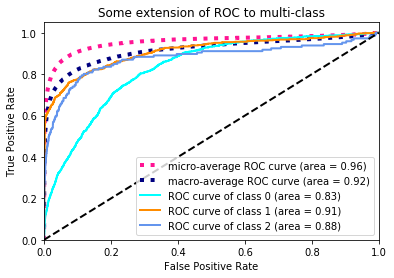

In [138]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

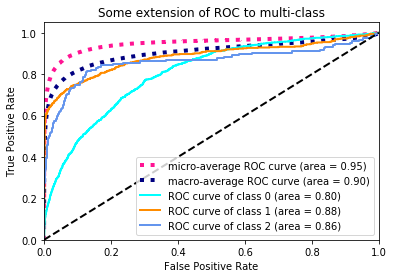

In [139]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

In [140]:
######################################
######### YOUR CODE HERE #############
######################################

When you are happy with the quality, create predictions for *test* set, which you will submit to Coursera.

In [141]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)######### YOUR CODE HERE #############
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [142]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [143]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	scanf, printf, malloc, fscanf, c
Top negative words:	objective c, objective, b c, c++ pointer, udp packets

Tag:	c++
Top positive words:	mfc, boostasio, boost, qt, c++
Top negative words:	c++ stl, opencv python, call member, c++ boost, python opencv

Tag:	linux
Top positive words:	killed, shared libraries, linux c, kernel space, linux
Top negative words:	linux windows, run bash, c unix, odbc driver, parent process



### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [144]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...


In [145]:
STUDENT_EMAIL = 'kuldeepsinh.singh3@gmail.com'# EMAIL 
STUDENT_TOKEN = 'fketxj4kOXdXMAeG'# TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json
7	java,swing
8	pytho...


If you want to submit these answers, run cell below

In [146]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
